### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

from textwrap import wrap

import seaborn as sns

### Loading the data

In [4]:
official_names = ['Benzyl_benzoate', 'm Anisaldehyde']

In [5]:
mix = np.loadtxt(os.getcwd()+'/1H_manisaldehyde_benzylbenzoate_DMSO.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 2, 4],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [6]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [7]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [8]:
mix = Spectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


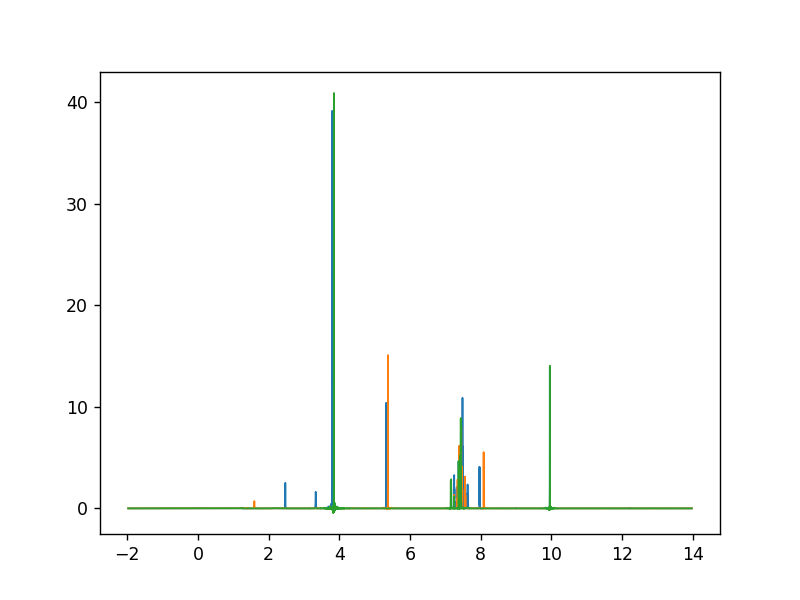

In [9]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Ground truth

In [10]:
protons = [12, 8]
molar_proportions = [0.3702, 0.6298]
molar_proportions

[0.3702, 0.6298]

In [11]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]
real_visible_proportions

[0.468568053328833, 0.5314319466711671]

### Alignment

In [12]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

In [13]:
# shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
# mix = shift_one_spectrum(mix, -0.1)

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
spectra_and_mixture = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [27]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [28]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


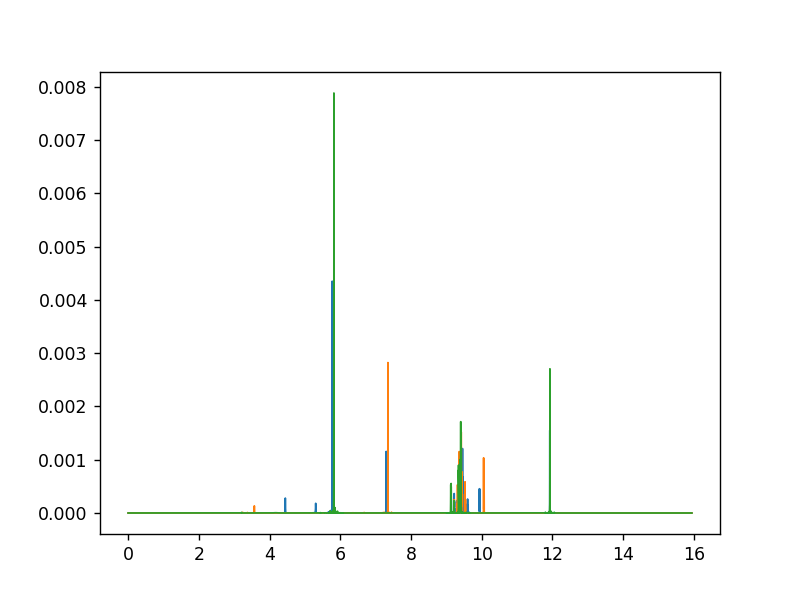

In [30]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Removing unnecessary data points

In [31]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [32]:
#3.5, 12
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 3.5, 12)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [35]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [36]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [37]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [38]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


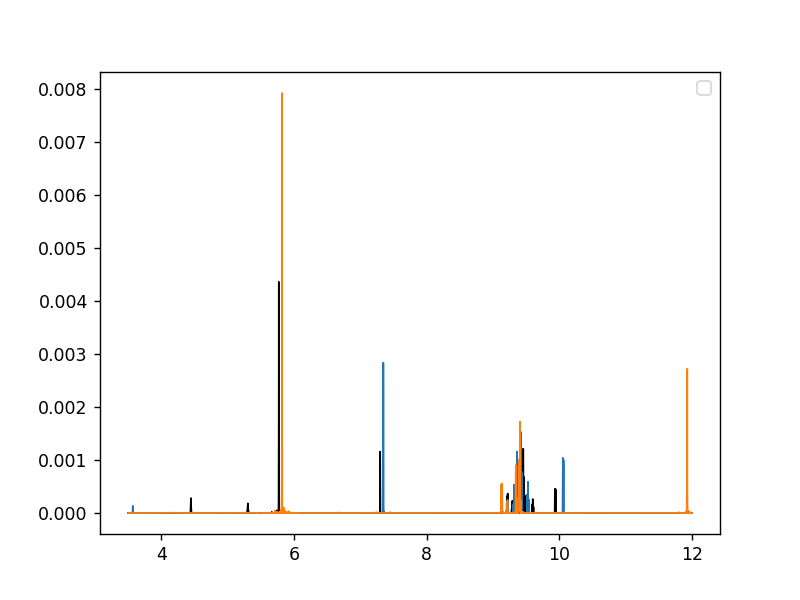

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [39]:
fig, ax = plt.subplots()
#fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
ax.legend()

### Finding best kappa

In [40]:
import time
import pandas as pd
import pulp

In [41]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [44]:
list_of_estimation_results = []
list_of_noise_prop = []
for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
    fixed_kappa = []
    fixed_kappa_noise_prop = []
    for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
        start = time.time()
        estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
        end = time.time()
        fixed_kappa.append(estimation['proportions'])
        fixed_kappa_noise_prop.append(estimation['proportion_of_noise_in_theoretical'])
        print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
        print('It took: '+str(end-start)+' seconds.')
        print(estimation['proportions'])
        print(estimation['proportion_of_noise_i+n_t+heoretical'])
    list_of_estimation_results.append(fixed_kappa)
    list_of_noise_prop.append(fixed_kappa_noise_prop)

Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3429474.06it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]


Interrupt request received


Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.86s/it]


Estimation for 0.01 and 0.01 done
It took: 205.0053632259369 seconds.
[0.26161890715899927, 0.2613460118679993]
0.3454520795919991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399601.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:21<00:00, 321.56s/it]


Estimation for 0.01 and 0.02 done
It took: 321.71469235420227 seconds.
[0.04767412502099987, 0.009842105601999974]
0.021416648943999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361980.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.54s/it]


Estimation for 0.01 and 0.03 done
It took: 183.70029544830322 seconds.
[0.00367388763799999, 0.0031352609939999916]
0.0003481455299999991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311321.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.25s/it]


Estimation for 0.01 and 0.04 done
It took: 163.4135868549347 seconds.
[0.0027268236979999926, 0.003137719433999992]
1.165269599999997e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347275.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.50s/it]


Estimation for 0.01 and 0.05 done
It took: 169.66173768043518 seconds.
[0.0027099115309999924, 0.003137767325999992]
3.76759399999999e-06


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340342.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.56s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 169.71788811683655 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376192.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.38s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 168.5347762107849 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353180.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.41s/it]


Estimation for 0.01 and 0.08 done
It took: 166.57553505897522 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365401.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.25s/it]


Estimation for 0.01 and 0.09 done
It took: 165.4037480354309 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392096.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.60s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 169.7609498500824 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274940.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.74s/it]


Estimation for 0.01 and 0.11 done
It took: 172.9019739627838 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3439427.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.02s/it]


Estimation for 0.01 and 0.12 done
It took: 168.1806344985962 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346165.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.26s/it]


Estimation for 0.01 and 0.13 done
It took: 157.42239713668823 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350781.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.76s/it]


Estimation for 0.01 and 0.14 done
It took: 159.91616582870483 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329418.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.08s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 159.23699259757996 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340685.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.65s/it]


Estimation for 0.01 and 0.16 done
It took: 157.8030662536621 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364182.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.22s/it]


Estimation for 0.01 and 0.17 done
It took: 159.37919092178345 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313439.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.88s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 155.0450255870819 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304219.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.08s/it]


Estimation for 0.01 and 0.19 done
It took: 153.23729062080383 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282505.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.04s/it]


Estimation for 0.01 and 0.2 done
It took: 154.19329452514648 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307785.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.88s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 143.03439903259277 seconds.
[0.0027025868019999928, 0.002644752927999993]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312033.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.01s/it]


Estimation for 0.01 and 0.22 done
It took: 157.1599678993225 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327337.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.21s/it]


Estimation for 0.01 and 0.23 done
It took: 157.37332677841187 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356679.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.81s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 154.9663746356964 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387189.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.14s/it]


Estimation for 0.01 and 0.25 done
It took: 153.2904770374298 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320373.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.46s/it]


Estimation for 0.01 and 0.26 done
It took: 156.6116590499878 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392981.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.98s/it]


Estimation for 0.01 and 0.27 done
It took: 154.12754678726196 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350915.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.43s/it]


Estimation for 0.01 and 0.28 done
It took: 154.58017587661743 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379037.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.94s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 156.09545254707336 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324427.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.78s/it]


Estimation for 0.01 and 0.3 done
It took: 155.9353461265564 seconds.
[0.002703560555999993, 0.003137787843999992]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336344.50it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [17:17<00:00, 1037.96s/it]


Estimation for 0.02 and 0.01 done
It took: 1038.1208982467651 seconds.
[0.5083647938949987, 0.48976233721299867]
0.9906885522309974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3009249.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.03s/it]


Estimation for 0.02 and 0.02 done
It took: 255.2045431137085 seconds.
[0.2857922788569992, 0.26321399744899926]
0.3401147029279991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360127.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.99s/it]


Estimation for 0.02 and 0.03 done
It took: 277.14613008499146 seconds.
[0.1855458833179995, 0.09116382726699974]
0.11723751444599968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263966.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:59<00:00, 539.48s/it]


Estimation for 0.02 and 0.04 done
It took: 539.637485742569 seconds.
[0.16186187201799956, 0.011855127472999969]
0.06391770362599983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321447.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.88s/it]


Estimation for 0.02 and 0.05 done
It took: 280.0419223308563 seconds.
[0.02014714445499995, 0.008854115252999976]
0.002896387003999992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3220904.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.00s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 268.159140586853 seconds.
[0.010090259205999975, 0.008879334619999976]
0.001121146161999997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379056.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.57s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 265.72900009155273 seconds.
[0.006146345230999983, 0.008832568639999976]
0.00040754176299999894


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371622.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.16s/it]


Estimation for 0.02 and 0.08 done
It took: 255.31507110595703 seconds.
[0.004271752150999989, 0.008733888210999977]
6.275244599999984e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320919.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.12s/it]


Estimation for 0.02 and 0.09 done
It took: 257.2733221054077 seconds.
[0.004268317583999989, 0.008636138319999978]
5.586297199999985e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304648.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.96s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 228.11673307418823 seconds.
[0.004265989773999989, 0.008533107601999977]
4.707395199999987e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302187.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.27s/it]


Estimation for 0.02 and 0.11 done
It took: 226.42726588249207 seconds.
[0.004266017181999988, 0.008478149274999977]
4.3842814999999886e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335964.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.05s/it]


Estimation for 0.02 and 0.12 done
It took: 232.20737218856812 seconds.
[0.004266045826999989, 0.008417197589999977]
4.066949199999989e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381711.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.62s/it]


Estimation for 0.02 and 0.13 done
It took: 232.7787845134735 seconds.
[0.004266076030999989, 0.008369619121999978]
3.635478399999991e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356717.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.69s/it]


Estimation for 0.02 and 0.14 done
It took: 233.84537148475647 seconds.
[0.004266121015999989, 0.008291993420999977]
3.0321223999999918e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294846.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.74s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 232.89815402030945 seconds.
[0.004266166000999988, 0.008212660950999977]
2.4386728999999936e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311639.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.02s/it]


Estimation for 0.02 and 0.16 done
It took: 239.17929458618164 seconds.
[0.004266219505999988, 0.008105646395999979]
1.8062791999999953e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299805.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.25s/it]


Estimation for 0.02 and 0.17 done
It took: 244.4168176651001 seconds.
[0.004266258897999989, 0.008060826191999979]
1.143539499999997e-05


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358913.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.28s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 234.4268181324005 seconds.
[0.004266310465999988, 0.007968867185999979]
4.691236999999987e-06


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382629.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.06s/it]


Estimation for 0.02 and 0.19 done
It took: 233.20782947540283 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352930.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.78s/it]


Estimation for 0.02 and 0.2 done
It took: 240.93520784378052 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384507.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.32s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 235.47568941116333 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319394.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.39s/it]


Estimation for 0.02 and 0.22 done
It took: 238.54840755462646 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3373896.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.85s/it]


Estimation for 0.02 and 0.23 done
It took: 234.99880480766296 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309542.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.13s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 237.28663635253906 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337695.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.66s/it]


Estimation for 0.02 and 0.25 done
It took: 239.82450413703918 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343088.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.20s/it]


Estimation for 0.02 and 0.26 done
It took: 236.3559205532074 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374518.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.51s/it]


Estimation for 0.02 and 0.27 done
It took: 234.6675992012024 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298280.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.16s/it]


Estimation for 0.02 and 0.28 done
It took: 235.32105445861816 seconds.
[0.004266342466999988, 0.00792052318599998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339427.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.62s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 240.77354288101196 seconds.
[0.004266277012999989, 0.00792052343199998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312051.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.42s/it]


Estimation for 0.02 and 0.3 done
It took: 237.58410835266113 seconds.
[0.004266342466999988, 0.00792052318599998]
0.0


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342001.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:12<00:00, 732.07s/it]


Estimation for 0.03 and 0.01 done
It took: 732.2230486869812 seconds.
[0.5157472238209987, 0.48385388193199874]
0.9937876420169973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283629.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.39s/it]


Estimation for 0.03 and 0.02 done
It took: 173.5508074760437 seconds.
[0.382719262378999, 0.5445682335619986]
0.8475319383259978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3411149.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.44s/it]


Estimation for 0.03 and 0.03 done
It took: 228.58804440498352 seconds.
[0.28642631669799923, 0.27296677474999925]
0.3112447245479992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366949.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.67s/it]


Estimation for 0.03 and 0.04 done
It took: 228.8361325263977 seconds.
[0.2896695949549992, 0.10319106158799972]
0.15306041583199959


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363544.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.82s/it]


Estimation for 0.03 and 0.05 done
It took: 199.96680736541748 seconds.
[0.23604138370199937, 0.10077295605599973]
0.055993105358999845


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375588.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.54s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 177.69846868515015 seconds.
[0.2147298680839994, 0.08729054345799976]
0.046755135082999874


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300735.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.23s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 170.3956277370453 seconds.
[0.19736351562599946, 0.08561708145899978]
0.04148937296499989


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351567.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.95s/it]


Estimation for 0.03 and 0.08 done
It took: 216.09735345840454 seconds.
[0.17429107767499952, 0.09880392456699974]
0.03499432672899991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3491800.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.98s/it]


Estimation for 0.03 and 0.09 done
It took: 162.13358545303345 seconds.
[0.11757357891599968, 0.10166331800099972]
0.020966447969999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355774.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:11<00:00, 431.97s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 432.12206506729126 seconds.
[0.02963637237699992, 0.1152224351729997]
0.005420450736999986


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301871.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.07s/it]


Estimation for 0.03 and 0.11 done
It took: 229.23179292678833 seconds.
[0.013584291238999964, 0.1154074510289997]
0.002185461287999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366969.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.47s/it]


Estimation for 0.03 and 0.12 done
It took: 186.6388020515442 seconds.
[0.009999816408999974, 0.11149534954099971]
0.0012749192799999965


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390839.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.63s/it]


Estimation for 0.03 and 0.13 done
It took: 273.78358125686646 seconds.
[0.009565026838999974, 0.10502345568099972]
0.001148745663999997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340227.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.09s/it]


Estimation for 0.03 and 0.14 done
It took: 192.25773572921753 seconds.
[0.009182778570999976, 0.10139271554499973]
0.0010699851669999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221507.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.99s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 210.16775035858154 seconds.
[0.009119857319999976, 0.09787118672099973]
0.0009921511029999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349937.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.75s/it]


Estimation for 0.03 and 0.16 done
It took: 145.92444849014282 seconds.
[0.009093924931999975, 0.09410501087799975]
0.0009037854269999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216109.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.27s/it]


Estimation for 0.03 and 0.17 done
It took: 217.43055176734924 seconds.
[0.009053365434999976, 0.09018382116299976]
0.0008266979199999979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390230.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.71s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 146.86337447166443 seconds.
[0.008928806468999975, 0.08773378832199977]
0.000768087748999998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335356.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.29s/it]


Estimation for 0.03 and 0.19 done
It took: 145.44723892211914 seconds.
[0.008968390911999975, 0.08466276959299977]
0.000720785473999998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3372263.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.24s/it]


Estimation for 0.03 and 0.2 done
It took: 177.4071831703186 seconds.
[0.009004266985999976, 0.08112380759699978]
0.0006603208449999983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3538101.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.99s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 149.14821004867554 seconds.
[0.009020896449999975, 0.07987506050999979]
0.0006305936999999983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343375.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:08<00:00, 368.38s/it]


Estimation for 0.03 and 0.22 done
It took: 368.5365138053894 seconds.
[0.009031503343999976, 0.07921969561899979]
0.0005956228489999984


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314264.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:13<00:00, 313.55s/it]


Estimation for 0.03 and 0.23 done
It took: 313.7087688446045 seconds.
[0.009092846744999977, 0.0763440863789998]
0.0005325941789999986


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3191475.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.57s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 282.7393660545349 seconds.
[0.009130723270999976, 0.0739870801529998]
0.00047174433999999877


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371215.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.92s/it]


Estimation for 0.03 and 0.25 done
It took: 239.0728096961975 seconds.
[0.009190301951999975, 0.0709962528769998]
0.0004040646889999989


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343413.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.98s/it]


Estimation for 0.03 and 0.26 done
It took: 260.155330657959 seconds.
[0.009216352354999976, 0.06980516205199983]
0.0003469768899999991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323559.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:30<00:00, 330.61s/it]


Estimation for 0.03 and 0.27 done
It took: 330.7871115207672 seconds.
[0.009239376998999975, 0.06759151255899983]
0.0002844774499999992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380578.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:05<00:00, 485.98s/it]


Estimation for 0.03 and 0.28 done
It took: 486.13640785217285 seconds.
[0.009271523629999976, 0.06636493872599981]
0.0002279822129999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335641.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:04<00:00, 364.26s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 364.4104425907135 seconds.
[0.009304554812999976, 0.06293398361499983]
0.00016691011599999958


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340380.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:30<00:00, 330.22s/it]


Estimation for 0.03 and 0.3 done
It took: 330.37205815315247 seconds.
[0.009306214101999976, 0.06253155079899983]
0.00012495843399999967


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387856.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:43<00:00, 763.06s/it]


Estimation for 0.04 and 0.01 done
It took: 763.2083849906921 seconds.
[0.5125067678179986, 0.48710785198499873]
0.9939002469829973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376484.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:07<00:00, 547.81s/it]


Estimation for 0.04 and 0.02 done
It took: 547.981440782547 seconds.
[0.21135542480799943, 0.7847187134799979]
0.9780834697719974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364743.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.73s/it]


Estimation for 0.04 and 0.03 done
It took: 186.8775851726532 seconds.
[0.43644730322899883, 0.28056989681599925]
0.4640786418709988


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384252.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.39s/it]


Estimation for 0.04 and 0.04 done
It took: 211.54938626289368 seconds.
[0.3474303147929991, 0.29698445396199924]
0.24253504253399935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267154.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.43s/it]


Estimation for 0.04 and 0.05 done
It took: 213.5882465839386 seconds.
[0.27521681677299925, 0.3424598094219991]
0.10108921345299973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305544.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.39s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 204.547434091568 seconds.
[0.2659331437709993, 0.32870035882599913]
0.09073785495399976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300289.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.06s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 221.21639108657837 seconds.
[0.25246935478599936, 0.3018909808499992]
0.0747401185049998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3419777.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:29<00:00, 389.73s/it]


Estimation for 0.04 and 0.08 done
It took: 389.90113520622253 seconds.
[0.20306504211299947, 0.2865856924249992]
0.053740368550999854


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14926.35it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334577.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.27s/it]


Estimation for 0.04 and 0.09 done
It took: 216.4423360824585 seconds.
[0.16420115434299956, 0.3090254838319992]
0.0398276423309999


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3427125.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.65s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 222.81645607948303 seconds.
[0.12586357060999967, 0.34184113448799913]
0.024767374678999934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3389209.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.10s/it]


Estimation for 0.04 and 0.11 done
It took: 267.2499084472656 seconds.
[0.09167239926899975, 0.35976988029399903]
0.014249148033999962


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338361.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.61s/it]


Estimation for 0.04 and 0.12 done
It took: 169.78560042381287 seconds.
[0.07694642875199979, 0.365598491183999]
0.007215154034999981


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353276.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.46s/it]


Estimation for 0.04 and 0.13 done
It took: 172.63899970054626 seconds.
[0.0764806632219998, 0.3603307679749991]
0.006941861287999982


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344865.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.19s/it]


Estimation for 0.04 and 0.14 done
It took: 169.35937118530273 seconds.
[0.07592874383299979, 0.35578618899399905]
0.006729779867999982


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334539.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.05s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 172.22039151191711 seconds.
[0.07614064912699979, 0.35099514361999906]
0.006117124287999984


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362926.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.51s/it]


Estimation for 0.04 and 0.16 done
It took: 167.68620038032532 seconds.
[0.07730572370799979, 0.34379856122899904]
0.005883221807999985


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325031.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.95s/it]


Estimation for 0.04 and 0.17 done
It took: 170.10502815246582 seconds.
[0.0780681232019998, 0.3397509252399991]
0.005610321803999985


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309337.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.06s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 170.2156684398651 seconds.
[0.07860721875899979, 0.33583109206399914]
0.005343927116999986


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375783.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.64s/it]


Estimation for 0.04 and 0.19 done
It took: 171.79770803451538 seconds.
[0.08019730650299979, 0.33083481554599914]
0.005102565499999986


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3473342.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.02s/it]


Estimation for 0.04 and 0.2 done
It took: 164.17192578315735 seconds.
[0.0803706915039998, 0.3281131554319991]
0.004817722022999987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3402763.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.83s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 166.98628973960876 seconds.
[0.08104482449699978, 0.3247918701269991]
0.004484980107999988


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3414671.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.48s/it]


Estimation for 0.04 and 0.22 done
It took: 168.63514947891235 seconds.
[0.08087370147899978, 0.32330531070699914]
0.004171622438999989


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316517.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.64s/it]


Estimation for 0.04 and 0.23 done
It took: 167.78591465950012 seconds.
[0.0804511394159998, 0.32179232080999914]
0.0038571409759999894


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3440276.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.63s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 173.79017162322998 seconds.
[0.0799931420249998, 0.32077339571599917]
0.0036199134789999905


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3233589.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.93s/it]


Estimation for 0.04 and 0.25 done
It took: 171.1158573627472 seconds.
[0.0786520251929998, 0.3209498597719992]
0.0033738296099999907


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302709.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.30s/it]


Estimation for 0.04 and 0.26 done
It took: 175.46442317962646 seconds.
[0.0771004331319998, 0.3212057340099992]
0.003091905566999992


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3502601.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.99s/it]


Estimation for 0.04 and 0.27 done
It took: 161.13196110725403 seconds.
[0.07605841438599979, 0.32166467341199917]
0.0028396440059999927


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3393374.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.04s/it]


Estimation for 0.04 and 0.28 done
It took: 164.20973229408264 seconds.
[0.0738577077879998, 0.3232679478039991]
0.002585291518999993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3433013.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.10s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 166.27059864997864 seconds.
[0.07166105142599981, 0.3249083897769991]
0.002338771849999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415588.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.95s/it]


Estimation for 0.04 and 0.3 done
It took: 166.10110306739807 seconds.
[0.06955961072499982, 0.3265290250719991]
0.0021077376589999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247166.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:20<00:00, 740.16s/it]


Estimation for 0.05 and 0.01 done
It took: 740.3219742774963 seconds.
[0.5039312762469986, 0.4957182222719987]
0.9942579005589973


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317645.29it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [16:57<00:00, 1017.12s/it]


Estimation for 0.05 and 0.02 done
It took: 1017.290910243988 seconds.
[0.5710168581749985, 0.4279751185919988]
0.9877107701929974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332868.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.61s/it]


Estimation for 0.05 and 0.03 done
It took: 291.76555728912354 seconds.
[0.40082611967299897, 0.5706521926489985]
0.8247028270819978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390328.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.77s/it]


Estimation for 0.05 and 0.04 done
It took: 252.9226427078247 seconds.
[0.4178325282869989, 0.377057770186999]
0.25864605291599935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359318.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.04s/it]


Estimation for 0.05 and 0.05 done
It took: 190.1916754245758 seconds.
[0.35083280618499907, 0.4214652482209989]
0.15610590910099958


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379915.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.76s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 220.92951202392578 seconds.
[0.29739742400499924, 0.4392146442889988]
0.10664389726299972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371545.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.62s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 226.78227066993713 seconds.
[0.2768085852369993, 0.44418490603699884]
0.08777113275999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367453.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.63s/it]


Estimation for 0.05 and 0.08 done
It took: 228.79379320144653 seconds.
[0.2675725272059993, 0.4483646962259988]
0.07809751617799979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192032.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.62s/it]


Estimation for 0.05 and 0.09 done
It took: 277.77300000190735 seconds.
[0.25155761279199934, 0.45593201075099876]
0.061644501050999834


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212473.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.33s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 223.4980664253235 seconds.
[0.2283849355319994, 0.4677701219519988]
0.036100917059999904


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3425160.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.55s/it]


Estimation for 0.05 and 0.11 done
It took: 232.70148348808289 seconds.
[0.2219199072499994, 0.46389825586799877]
0.023620898522999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381555.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.18s/it]


Estimation for 0.05 and 0.12 done
It took: 224.35311818122864 seconds.
[0.21768247334799942, 0.4622061907229988]
0.012112678325999967


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3370632.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.85s/it]


Estimation for 0.05 and 0.13 done
It took: 222.0223286151886 seconds.
[0.21502858810699943, 0.46243407040399875]
0.011278435723999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346203.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.54s/it]


Estimation for 0.05 and 0.14 done
It took: 233.6921079158783 seconds.
[0.21379204526599943, 0.46229824727699875]
0.01103069175399997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375764.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.32s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 204.49077606201172 seconds.
[0.21228586265099944, 0.46261894715399876]
0.010303471073999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354717.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.34s/it]


Estimation for 0.05 and 0.16 done
It took: 217.5022327899933 seconds.
[0.21092106415499945, 0.4627849560309988]
0.010065005325999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390230.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.42s/it]


Estimation for 0.05 and 0.17 done
It took: 188.5676064491272 seconds.
[0.20851465387799945, 0.4628742553339988]
0.009840687998999974


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3421256.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.94s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 187.09037852287292 seconds.
[0.20731928559899945, 0.4620195504039988]
0.009502651886999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3461001.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.02s/it]


Estimation for 0.05 and 0.19 done
It took: 184.1774935722351 seconds.
[0.20509056856799945, 0.4614673782349988]
0.009137104437999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354659.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.44s/it]


Estimation for 0.05 and 0.2 done
It took: 187.596853017807 seconds.
[0.20326580966399946, 0.4612295393869988]
0.008798279866999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382493.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.32s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 175.47595858573914 seconds.
[0.20071763538099946, 0.46073446995299877]
0.008318046499999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3416365.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.16s/it]


Estimation for 0.05 and 0.22 done
It took: 175.31158685684204 seconds.
[0.19936254072699947, 0.4596693240089988]
0.00775265353999998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3503712.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.96s/it]


Estimation for 0.05 and 0.23 done
It took: 204.11251163482666 seconds.
[0.19713818171799946, 0.45934796741799877]
0.007244581040999981


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3395815.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.67s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 177.8383162021637 seconds.
[0.19401208080899948, 0.45974908454399877]
0.006856296027999982


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3430880.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.48s/it]


Estimation for 0.05 and 0.25 done
It took: 193.63874411582947 seconds.
[0.1910407739099995, 0.46010794294599877]
0.006485577281999983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351145.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.15s/it]


Estimation for 0.05 and 0.26 done
It took: 167.30348110198975 seconds.
[0.1872696660069995, 0.4605541675399988]
0.006068847846999984


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162956.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.12s/it]


Estimation for 0.05 and 0.27 done
It took: 180.27780675888062 seconds.
[0.1838909147219995, 0.4609382661049988]
0.005645552623999985


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368635.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.07s/it]


Estimation for 0.05 and 0.28 done
It took: 165.2421519756317 seconds.
[0.17981703200799953, 0.46143392647199877]
0.005214352245999986


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310534.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.20s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 164.35589623451233 seconds.
[0.17546362760899953, 0.46193899665799876]
0.004819064507999987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358836.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.90s/it]


Estimation for 0.05 and 0.3 done
It took: 189.06154656410217 seconds.
[0.17208735280299953, 0.4623512383429988]
0.004486503745999988


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3401260.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:18<00:00, 738.28s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 738.4367847442627 seconds.
[0.4868187408319987, 0.5128852331859987]
0.9945532783789973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353276.18it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [17:42<00:00, 1062.23s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 1062.3860576152802 seconds.
[0.5656595533399984, 0.4335364298409988]
0.9889445970259974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368557.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.69s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 153.8517942428589 seconds.
[0.379837043643999, 0.5966639108179984]
0.8424550574559978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364782.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.50s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 210.68956589698792 seconds.
[0.5372144158579986, 0.32976526990599914]
0.365440648788999


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369022.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.39s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 232.55246710777283 seconds.
[0.39566973741799893, 0.4228643289729989]
0.16685599765799955


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371331.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.83s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 180.99334073066711 seconds.
[0.375622711107999, 0.44250803538499883]
0.11526212661099969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3101870.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.54s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 217.7221221923828 seconds.
[0.372156371759999, 0.44875288729099877]
0.09876618205499973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333589.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.04s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 236.19418168067932 seconds.
[0.374788151462999, 0.4535252359139988]
0.08774421035399976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346949.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.60s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 215.75291657447815 seconds.
[0.370649057806999, 0.4635513877419988]
0.06428855531699984


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342039.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.39s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 257.5683329105377 seconds.
[0.35690629356199904, 0.4701306358949987]
0.047014545913999874


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287685.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.09s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 256.27281761169434 seconds.
[0.3413541450399991, 0.47454587353399874]
0.03483097146599991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3168382.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.47s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 201.62508630752563 seconds.
[0.33311074270499913, 0.48111648311399874]
0.01819641127899995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352354.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.10s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 196.25999522209167 seconds.
[0.33117982206999913, 0.4772235548859987]
0.016747666464999957


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317814.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.03s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 189.19105696678162 seconds.
[0.3371800038039991, 0.4615939946429988]
0.013686579666999963


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315785.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.91s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 184.06690287590027 seconds.
[0.3383310888139991, 0.4538351709309988]
0.012352741093999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331237.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.54s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 204.69707036018372 seconds.
[0.33486520317199914, 0.4538298491049988]
0.012049175119999967


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366175.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.26s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 226.41685390472412 seconds.
[0.3321578056369991, 0.45385107123599877]
0.011816670788999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368150.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.12s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 233.2759473323822 seconds.
[0.3286250745279991, 0.4541943073319988]
0.011552643594999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329665.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.44s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 195.59171795845032 seconds.
[0.3256662401249991, 0.45447343948699875]
0.01126705395699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3372652.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.72s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 177.89573645591736 seconds.
[0.3224542998829992, 0.4546304404929988]
0.01095626322699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343318.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.24s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 175.41809129714966 seconds.
[0.3208749066399992, 0.4538208846839988]
0.010354130250999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339713.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.29s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 170.46966409683228 seconds.
[0.31859490761399917, 0.45347351819699877]
0.009755410117999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337866.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.77s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 180.92831563949585 seconds.
[0.3167004923459992, 0.4533813751089988]
0.009278081861999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332318.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.13s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 179.282860994339 seconds.
[0.31588226503599914, 0.4527417642519988]
0.008824321250999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309262.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.98s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 217.16174721717834 seconds.
[0.3149607912309992, 0.45175441610599876]
0.008279452660999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382688.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.65s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 163.79863214492798 seconds.
[0.31399840308999916, 0.4513797258699988]
0.007816696936999979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353026.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.22s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 167.36813950538635 seconds.
[0.31263133656699915, 0.4516472908519988]
0.00746308975499998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310722.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.96s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 176.14379906654358 seconds.
[0.3115724554269992, 0.4518929406199988]
0.007086224110999981


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356159.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.96s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 162.13145446777344 seconds.
[0.31048733722999916, 0.45211454844299875]
0.006779732185999982


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349170.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.25s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 170.4206771850586 seconds.
[0.3095403911859992, 0.45226525803399875]
0.006495234207999983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331029.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:17<00:00, 857.47s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 857.6261796951294 seconds.
[0.4815536171559987, 0.5181954673369986]
0.9948106013169974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3440478.43it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:11<00:00, 1091.77s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 1091.9260516166687 seconds.
[0.5779658198789984, 0.42143543831199887]
0.9900043034149973


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3402822.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.10s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 174.2743058204651 seconds.
[0.3276769608369991, 0.6565238290269982]
0.8857528484759977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3377906.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.30s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 216.47570705413818 seconds.
[0.5719348821399984, 0.3149481556549992]
0.39956786435799896


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313776.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.04s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 234.21049213409424 seconds.
[0.4209852518789989, 0.4195858860099989]
0.18195597083399953


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289755.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.37s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 181.52400016784668 seconds.
[0.3878350815089989, 0.44386229282699885]
0.11802994669299968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346815.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.77s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 276.92372703552246 seconds.
[0.380140628981999, 0.4535124994399988]
0.09007452175199976


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365826.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.61s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 206.76402139663696 seconds.
[0.38797648339999896, 0.46256758422799876]
0.0705694172509998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3395303.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.21s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 244.39396381378174 seconds.
[0.39461706442399896, 0.4705398989339987]
0.053387917673999856


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2976159.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.08s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 207.27198958396912 seconds.
[0.39740301624399893, 0.47251622247999875]
0.04622639517499987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375841.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.70s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 195.87882256507874 seconds.
[0.4072709394089989, 0.4830108417539987]
0.02229453714399994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298615.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.81s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 229.97592520713806 seconds.
[0.4081610355009989, 0.48348834842599875]
0.020313616968999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328358.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.03s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 205.20677065849304 seconds.
[0.4087980818249989, 0.4825786133159987]
0.01977781037899995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313476.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.41s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 225.56750464439392 seconds.
[0.41097506966699887, 0.47995899997999875]
0.018603496156999952


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331029.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.16s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 251.34034752845764 seconds.
[0.4102084760999989, 0.4783891958939987]
0.016329960220999955


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3418380.17it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:35:40<00:00, 5740.69s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 5740.845669269562 seconds.
[0.4124662392759989, 0.47335540980499874]
0.014529587068999962


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3036974.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:22<00:00, 742.46s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 742.6270437240601 seconds.
[0.4147500092829989, 0.46952588255699873]
0.013486434366999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3161743.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.96s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 178.1227879524231 seconds.
[0.4147810846229989, 0.46940074151399874]
0.013194285499999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303287.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.34s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 248.49893164634705 seconds.
[0.41460779889299887, 0.46944547793999875]
0.012925697815999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368460.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.23s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 259.3957951068878 seconds.
[0.4147927322749989, 0.46935468923699875]
0.012499260037999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3091860.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.43s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 196.60055017471313 seconds.
[0.41470371734099887, 0.46949705156599875]
0.012086306535999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2770969.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.83s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 249.02607226371765 seconds.
[0.4143594128039989, 0.4698308481299987]
0.01159497182699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3124334.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.06s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 276.2420105934143 seconds.
[0.4142506612209989, 0.4695811865569987]
0.01099248099599997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226389.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.33s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 265.4942886829376 seconds.
[0.4139880649649989, 0.4694555777819987]
0.010526777677999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265969.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.32s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 205.5101306438446 seconds.
[0.4134713834299989, 0.4697009767449987]
0.010089949061999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3158263.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.67s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 196.84646201133728 seconds.
[0.4128765160229989, 0.4698819929599987]
0.009606543682999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2963099.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.90s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 258.0969891548157 seconds.
[0.4120783973249989, 0.4698053934279987]
0.009034734532999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3125601.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.97s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 209.13100004196167 seconds.
[0.4112352879909989, 0.4702338810059987]
0.008621782260999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3176238.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.82s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 214.98784971237183 seconds.
[0.41019950960399887, 0.4709834352819987]
0.008337190476999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209849.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.01s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 180.18191814422607 seconds.
[0.4083229822229989, 0.47208421616199875]
0.008032032960999979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2929544.07it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:22<00:00, 1102.44s/it]


Estimation for 0.08 and 0.01 done
It took: 1102.6146368980408 seconds.
[0.4131019696859989, 0.5867692007839984]
0.9957910211029973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3006683.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:51<00:00, 771.49s/it]


Estimation for 0.08 and 0.02 done
It took: 771.6712746620178 seconds.
[0.5672433481019984, 0.43220232433499883]
0.9903417995689974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2993293.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.59s/it]


Estimation for 0.08 and 0.03 done
It took: 187.7945590019226 seconds.
[0.2613951034439993, 0.730261745768998]
0.9369228086569975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3211557.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.25s/it]


Estimation for 0.08 and 0.04 done
It took: 167.4113290309906 seconds.
[0.6431534367949984, 0.2949506493869992]
0.5922336978389985


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280887.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.48s/it]


Estimation for 0.08 and 0.05 done
It took: 250.64032101631165 seconds.
[0.4586749255499988, 0.40389868533599893]
0.2167066440129994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224772.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.80s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 223.96670484542847 seconds.
[0.39390701153999896, 0.4490835632419988]
0.11093224989699971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285324.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.35s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 207.50413393974304 seconds.
[0.39658780157699897, 0.46077264162499876]
0.07585147657599979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3177014.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.70s/it]


Estimation for 0.08 and 0.08 done
It took: 174.88999557495117 seconds.
[0.40231643535299894, 0.4701255324909987]
0.05531109107699986


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311227.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.81s/it]


Estimation for 0.08 and 0.09 done
It took: 211.96734976768494 seconds.
[0.40332472029299893, 0.4726150095309987]
0.04920670565999987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289163.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.71s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 170.87361884117126 seconds.
[0.4124309413349989, 0.4847343901319987]
0.024432393819999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3400667.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.08s/it]


Estimation for 0.08 and 0.11 done
It took: 196.25375771522522 seconds.
[0.4146492058239989, 0.4839925748809987]
0.020875534503999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3214978.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.63s/it]


Estimation for 0.08 and 0.12 done
It took: 209.81449508666992 seconds.
[0.4147688699799989, 0.4837096248359987]
0.020291785845999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3270695.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.19s/it]


Estimation for 0.08 and 0.13 done
It took: 180.34891939163208 seconds.
[0.4147552700809989, 0.48353016609899874]
0.019983865403999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317758.10it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:51:28<00:00, 6688.04s/it]


Estimation for 0.08 and 0.14 done
It took: 6688.227831840515 seconds.
[0.4157424396509989, 0.4822733747929987]
0.01900503955899995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415548.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.13s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 174.29774403572083 seconds.
[0.4154564608039989, 0.4819839607629987]
0.01838826635499995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3116268.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.01s/it]


Estimation for 0.08 and 0.16 done
It took: 234.16022443771362 seconds.
[0.4137455355609989, 0.48157553646199874]
0.016819888119999956


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3445986.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.75s/it]


Estimation for 0.08 and 0.17 done
It took: 268.92865657806396 seconds.
[0.4126705989809989, 0.4806627651059987]
0.01527323013299996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3386621.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.90s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 237.04815912246704 seconds.
[0.4125840414469989, 0.4788748156879987]
0.013673840076999963


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365768.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.47s/it]


Estimation for 0.08 and 0.19 done
It took: 221.6300630569458 seconds.
[0.4132666028329989, 0.47752311119999874]
0.012739868850999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378296.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.23s/it]


Estimation for 0.08 and 0.2 done
It took: 171.38734245300293 seconds.
[0.4134930895989989, 0.47740259630899873]
0.012285259711999967


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361246.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.35s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 191.5127718448639 seconds.
[0.4137573876089989, 0.47747652672499874]
0.011793590868999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3420617.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.01s/it]


Estimation for 0.08 and 0.22 done
It took: 170.16386461257935 seconds.
[0.4138973336659989, 0.47760954808199874]
0.01132314358399997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397904.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.07s/it]


Estimation for 0.08 and 0.23 done
It took: 223.23042464256287 seconds.
[0.4139477548519989, 0.4777972638869987]
0.010964188288999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384585.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.81s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 232.97268915176392 seconds.
[0.4138303009569989, 0.4781198422979987]
0.010557677507999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3477840.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.39s/it]


Estimation for 0.08 and 0.25 done
It took: 223.5585172176361 seconds.
[0.4139607992519989, 0.47801426693599874]
0.010040753372999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275380.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.59s/it]


Estimation for 0.08 and 0.26 done
It took: 172.7454810142517 seconds.
[0.4139629627569989, 0.4780652007849987]
0.009556939194999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354063.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.99s/it]


Estimation for 0.08 and 0.27 done
It took: 165.14573121070862 seconds.
[0.4139892846609989, 0.47811006917099874]
0.009169095148999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338551.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.96s/it]


Estimation for 0.08 and 0.28 done
It took: 229.11571264266968 seconds.
[0.41381258488599887, 0.47830016388999874]
0.008788588430999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3389621.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.26s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 216.43635153770447 seconds.
[0.4137071565329989, 0.4782407128259987]
0.008323496046999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3404860.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.64s/it]


Estimation for 0.08 and 0.3 done
It took: 159.7985818386078 seconds.
[0.4136637778449989, 0.4782318881479987]
0.00791696242999998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332830.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:45<00:00, 825.27s/it]


Estimation for 0.09 and 0.01 done
It took: 825.4265327453613 seconds.
[0.36171476032499905, 0.6382213876299984]
0.9963943670029973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354659.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:04<00:00, 844.92s/it]


Estimation for 0.09 and 0.02 done
It took: 845.0843071937561 seconds.
[0.5553862302399986, 0.44410941786799885]
0.9906163329749973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3423938.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:54<00:00, 714.56s/it]


Estimation for 0.09 and 0.03 done
It took: 714.7435710430145 seconds.
[0.380207345977999, 0.6159469682369983]
0.9656787110419974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342401.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.27s/it]


Estimation for 0.09 and 0.04 done
It took: 239.42215728759766 seconds.
[0.6193356385659984, 0.3405424337189991]
0.7133254084129981


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344444.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.93s/it]


Estimation for 0.09 and 0.05 done
It took: 209.09018397331238 seconds.
[0.5174046524959987, 0.373736449835999]
0.2794037229519993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354275.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.32s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 160.47930550575256 seconds.
[0.4101145289599989, 0.4561049795649988]
0.10381224736699972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397608.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.64s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 184.79012775421143 seconds.
[0.4126009801159989, 0.4692181294659987]
0.06170609274999983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3411070.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:45<00:00, 345.68s/it]


Estimation for 0.09 and 0.08 done
It took: 345.86055302619934 seconds.
[0.4125046845729989, 0.47250224412999875]
0.05238542578499986


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3411130.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.34s/it]


Estimation for 0.09 and 0.09 done
It took: 201.48850560188293 seconds.
[0.4224744372599989, 0.4840472373469987]
0.026813804215999926


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350435.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.56s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 225.71746063232422 seconds.
[0.42394328459199887, 0.48585710774299873]
0.02214655451799994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353276.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.59s/it]


Estimation for 0.09 and 0.11 done
It took: 197.78204035758972 seconds.
[0.42429915054599887, 0.4854217019179987]
0.021158298725999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3079127.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.70s/it]


Estimation for 0.09 and 0.12 done
It took: 186.8974313735962 seconds.
[0.4242024238099989, 0.4850845404729987]
0.020694747875999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159405.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.58s/it]


Estimation for 0.09 and 0.13 done
It took: 223.75554633140564 seconds.
[0.4244065704739989, 0.48461742229599875]
0.020328780069999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3101344.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.01s/it]


Estimation for 0.09 and 0.14 done
It took: 197.20777988433838 seconds.
[0.4258041107809989, 0.48242168835399873]
0.019208238143999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3062296.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.62s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 255.78532099723816 seconds.
[0.4257309204239989, 0.4822226157039987]
0.01888211576899995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3121086.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.04s/it]


Estimation for 0.09 and 0.16 done
It took: 248.21416687965393 seconds.
[0.4256255843669989, 0.48226778588799873]
0.018632039532999953


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3029399.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.76s/it]


Estimation for 0.09 and 0.17 done
It took: 189.93799591064453 seconds.
[0.4244200889269989, 0.4824936822649987]
0.01783410432199995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2903550.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.45s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 250.6255383491516 seconds.
[0.42192013710499887, 0.48262107618399874]
0.016277050815999956


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19553.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2938499.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.83s/it]


Estimation for 0.09 and 0.19 done
It took: 243.0333013534546 seconds.
[0.4194400480939989, 0.4821867938039987]
0.013962417409999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3118176.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.98s/it]


Estimation for 0.09 and 0.2 done
It took: 241.14858508110046 seconds.
[0.4180677120809989, 0.4818671117559987]
0.012081338020999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3048804.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.00s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 239.18289518356323 seconds.
[0.4179952707629989, 0.48205284531299875]
0.011558019937999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3011338.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.51s/it]


Estimation for 0.09 and 0.22 done
It took: 171.6863570213318 seconds.
[0.4177885873439989, 0.4822133347099987]
0.011161427401999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3039844.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.66s/it]


Estimation for 0.09 and 0.23 done
It took: 225.86153316497803 seconds.
[0.4177774847609989, 0.4823753795049987]
0.01076130487999997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221081.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.84s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 172.02738165855408 seconds.
[0.41757514714299887, 0.4826270276779987]
0.010385176271999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291808.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.52s/it]


Estimation for 0.09 and 0.25 done
It took: 215.71534276008606 seconds.
[0.4174828299639989, 0.4827839845049987]
0.009998588619999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2852200.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.71s/it]


Estimation for 0.09 and 0.26 done
It took: 251.88621544837952 seconds.
[0.4174353966269989, 0.4828538278639987]
0.009556161604999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3083815.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:50<00:00, 770.26s/it]


Estimation for 0.09 and 0.27 done
It took: 770.4317932128906 seconds.
[0.41705643073799886, 0.4830127199499987]
0.009130314248999976


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348021.65it/s]
Deconvolving chunks: 100%|███████████████████| 1/1 [8:09:10<00:00, 29350.43s/it]


Estimation for 0.09 and 0.28 done
It took: 29350.593010902405 seconds.
[0.4167683508189989, 0.4831681934429987]
0.008773124286999978


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3550310.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.96s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 172.13559103012085 seconds.
[0.41678860987299887, 0.48315847661699873]
0.008415956960999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3441874.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.28s/it]


Estimation for 0.09 and 0.3 done
It took: 167.46033763885498 seconds.
[0.4164820549349989, 0.4831346984829987]
0.00802447936999998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3388895.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:42<00:00, 822.36s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 822.5350368022919 seconds.
[0.3403012828849991, 0.6596711533689982]
0.9967021132009973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350666.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:30<00:00, 870.51s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 870.6669261455536 seconds.
[0.5421932115609985, 0.4573571678759988]
0.9909259001519973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361285.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:16<00:00, 796.27s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 796.4283163547516 seconds.
[0.5222453408969986, 0.4762219140389987]
0.9797467621299973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3405989.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.36s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 246.54113245010376 seconds.
[0.5087064605909987, 0.4607161913929988]
0.7751963690129979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3458098.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.14s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 221.28796553611755 seconds.
[0.5450079698629986, 0.365361172745999]
0.2967361093649992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390956.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.45s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 215.60119223594666 seconds.
[0.44531088175199884, 0.4494726613099988]
0.1170640907429997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366543.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.77s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 171.93028116226196 seconds.
[0.4155845777539989, 0.4726225128659987]
0.05816010161499985


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415149.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.43s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 216.58208894729614 seconds.
[0.4264723923189989, 0.4842504953299987]
0.02973585933199992


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3424018.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.29s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 213.43613600730896 seconds.
[0.42952067425199886, 0.48615181562599874]
0.022962415811999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3403020.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.22s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 244.37415409088135 seconds.
[0.42985571355999885, 0.4860639050419987]
0.02193770533199994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294031.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.79s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 210.9736635684967 seconds.
[0.42996167956599884, 0.4860895996219987]
0.021475733617999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362076.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:56<00:00, 836.51s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 836.6644756793976 seconds.
[0.43023996053799884, 0.48538352858399875]
0.020831832524999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290309.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.67s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 221.86502838134766 seconds.
[0.4302648906859988, 0.48538917617599875]
0.020581810695999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320034.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.88s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 206.04490327835083 seconds.
[0.4307585729349988, 0.48435799053699874]
0.019631963732999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3165162.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.22s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 222.39290118217468 seconds.
[0.43092883250599884, 0.48412862100799875]
0.019218007456999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2800061.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.84s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 211.03090119361877 seconds.
[0.43107915965099886, 0.48397312804799875]
0.01885931672699995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2787807.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.13s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 196.32623291015625 seconds.
[0.43117919613499883, 0.48398045588599875]
0.01853365899599995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219629.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.85s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 203.01454329490662 seconds.
[0.4315946380519988, 0.4829844472659987]
0.017286922957999953


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277727.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:44<00:00, 284.16s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 284.3247539997101 seconds.
[0.4317797653489988, 0.4831561784789987]
0.01563749218299996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31068.92it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3100966.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.33s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 261.5083050727844 seconds.
[0.43053805926699884, 0.4838925919579987]
0.013214663596999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3110026.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.52s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 221.70494627952576 seconds.
[0.42929505497599885, 0.4844601116369987]
0.011602343909999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3023266.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.18s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 185.35028767585754 seconds.
[0.4291783562579988, 0.48461364380699873]
0.011096910263999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219575.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.27s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 267.47308468818665 seconds.
[0.42918865167399883, 0.4847750904279987]
0.010673351446999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328983.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.85s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 267.04496121406555 seconds.
[0.42920699706899884, 0.48492796962999873]
0.010298054830999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159576.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.77s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 253.96964859962463 seconds.
[0.42930007931399883, 0.48502281144799875]
0.009914406660999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3165966.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.60s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 258.80089378356934 seconds.
[0.4292749166759988, 0.4851630821439987]
0.009607925048999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274922.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.95s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 254.15139269828796 seconds.
[0.42913668824299883, 0.4852840885319987]
0.009306399837999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3214131.66it/s]
Deconvolving chunks: 100%|███████████████████| 1/1 [8:45:32<00:00, 31532.82s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 31532.98794555664 seconds.
[0.42898825257999884, 0.4853000241809987]
0.008910657934999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3437872.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.08s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 225.23634552955627 seconds.
[0.4289263184689988, 0.4852370924789987]
0.008531472643999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240480.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.67s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 160.8497393131256 seconds.
[0.42889596485799886, 0.4852814637009987]
0.008268258411999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3525784.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:42<00:00, 522.98s/it]


Estimation for 0.11 and 0.01 done
It took: 523.1437604427338 seconds.
[0.32011107030199915, 0.6798889296979982]
0.9969426645039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344903.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:51<00:00, 591.15s/it]


Estimation for 0.11 and 0.02 done
It took: 591.3069286346436 seconds.
[0.5354665504309986, 0.4641449659119988]
0.9911973682869973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224079.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:28<00:00, 628.29s/it]


Estimation for 0.11 and 0.03 done
It took: 628.4694926738739 seconds.
[0.5584688831409985, 0.44056860761699884]
0.9834782044359973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3258135.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.07s/it]


Estimation for 0.11 and 0.04 done
It took: 255.25682139396667 seconds.
[0.4674539629529988, 0.5116027258499987]
0.8053670761499979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3200828.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.74s/it]


Estimation for 0.11 and 0.05 done
It took: 230.92364120483398 seconds.
[0.5681135837919985, 0.3573652808949991]
0.3124424186639992


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3133951.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.97s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 216.1365189552307 seconds.
[0.46612006222699875, 0.44203620163799884]
0.13351856857999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379720.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.25s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 201.4074034690857 seconds.
[0.42823447650299884, 0.48371866250699874]
0.038546626866999896


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261239.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.61s/it]


Estimation for 0.11 and 0.08 done
It took: 213.80027055740356 seconds.
[0.42954914098499886, 0.4875842691409987]
0.024404316779999935


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300344.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.09s/it]


Estimation for 0.11 and 0.09 done
It took: 205.24482369422913 seconds.
[0.4302852906149988, 0.4868307100809987]
0.022699303570999942


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362289.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.85s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 266.0005919933319 seconds.
[0.4305264913799988, 0.4864772324639987]
0.022003642283999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291734.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:06<00:00, 306.24s/it]


Estimation for 0.11 and 0.11 done
It took: 306.3986072540283 seconds.
[0.4306888133619988, 0.48617153694899873]
0.021423770234999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221560.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.36s/it]


Estimation for 0.11 and 0.12 done
It took: 197.52631306648254 seconds.
[0.43076945845799886, 0.48608395519599873]
0.021007368335999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3153924.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.24s/it]


Estimation for 0.11 and 0.13 done
It took: 184.39859461784363 seconds.
[0.43086750503399884, 0.48587221361899874]
0.020578474150999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3385955.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.50s/it]


Estimation for 0.11 and 0.14 done
It took: 179.65884804725647 seconds.
[0.43089914937999885, 0.4857998895089987]
0.020235160761999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3138672.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.96s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 183.12273144721985 seconds.
[0.43130864128299884, 0.4847870390969987]
0.01923008394699995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366697.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.48s/it]


Estimation for 0.11 and 0.16 done
It took: 179.6425268650055 seconds.
[0.4313859150639988, 0.4847508161649987]
0.018810200120999952


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32140.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3040965.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.11s/it]


Estimation for 0.11 and 0.17 done
It took: 182.29758524894714 seconds.
[0.43164138178399886, 0.4849413616309987]
0.01801531252599995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248463.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.77s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 200.95782709121704 seconds.
[0.43207238849199886, 0.4850604810399987]
0.016919961736999955


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325371.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.08s/it]


Estimation for 0.11 and 0.19 done
It took: 191.23447704315186 seconds.
[0.43255341288699883, 0.48547783739399875]
0.01564450001699996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346356.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.52s/it]


Estimation for 0.11 and 0.2 done
It took: 204.6906702518463 seconds.
[0.43314594795999883, 0.4854553790769987]
0.013705531436999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375608.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.34s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 242.5204644203186 seconds.
[0.43347700546199885, 0.4847194244019987]
0.01191371694699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379739.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.29s/it]


Estimation for 0.11 and 0.22 done
It took: 246.44056177139282 seconds.
[0.43305204524999885, 0.48510994334299873]
0.01085238260699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392882.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.92s/it]


Estimation for 0.11 and 0.23 done
It took: 238.07593965530396 seconds.
[0.43306585762899885, 0.4852841358139987]
0.010463127230999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340685.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.85s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 185.01286721229553 seconds.
[0.43309686876399883, 0.48544838383399874]
0.010085214659999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3517417.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.65s/it]


Estimation for 0.11 and 0.25 done
It took: 211.80567693710327 seconds.
[0.4332788525999988, 0.4855013590939987]
0.009730287831999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3258063.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.48s/it]


Estimation for 0.11 and 0.26 done
It took: 184.6430606842041 seconds.
[0.4332917686269988, 0.48562254664599874]
0.009462837610999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310197.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.36s/it]


Estimation for 0.11 and 0.27 done
It took: 165.53731060028076 seconds.
[0.43328151165699885, 0.4857370404379987]
0.009206463952999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265386.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.33s/it]


Estimation for 0.11 and 0.28 done
It took: 268.51893377304077 seconds.
[0.4332726912889988, 0.48578163583699874]
0.008916048006999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316160.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.39s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 165.54490518569946 seconds.
[0.43323838573499884, 0.48577499531999874]
0.008538059567999978


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379661.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.31s/it]


Estimation for 0.11 and 0.3 done
It took: 166.4755461215973 seconds.
[0.4331243153939988, 0.4858339264139987]
0.008271722830999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3377029.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:09<00:00, 789.82s/it]


Estimation for 0.12 and 0.01 done
It took: 789.9746146202087 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353160.95it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [16:44<00:00, 1004.76s/it]


Estimation for 0.12 and 0.02 done
It took: 1004.9251444339752 seconds.
[0.5040334250119987, 0.49569450389399866]
0.9919011556939973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321240.21it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [2:34:39<00:00, 9279.97s/it]


Estimation for 0.12 and 0.03 done
It took: 9280.131819725037 seconds.
[0.5625544160209984, 0.4365991037049988]
0.9842875266899973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35848.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3172486.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.35s/it]


Estimation for 0.12 and 0.04 done
It took: 278.51450514793396 seconds.
[0.4583699085839988, 0.5283789236719986]
0.8196034271849978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289126.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.05s/it]


Estimation for 0.12 and 0.05 done
It took: 243.23155903816223 seconds.
[0.5886633508599984, 0.3573347199009991]
0.31480312234899915


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2829386.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.08s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 203.28998589515686 seconds.
[0.4950307306279987, 0.4383927201749988]
0.1414981767319996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285895.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.55s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 215.74340796470642 seconds.
[0.43629272918699885, 0.4852734956099987]
0.0361735285459999


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314902.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.39s/it]


Estimation for 0.12 and 0.08 done
It took: 192.5860459804535 seconds.
[0.43219935312499885, 0.48784709418899874]
0.025045284089999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224985.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.13s/it]


Estimation for 0.12 and 0.09 done
It took: 301.2947402000427 seconds.
[0.43189658321999885, 0.48709987165699875]
0.023251762350999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212209.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.89s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 187.06924962997437 seconds.
[0.4317095901329988, 0.4866252363099987]
0.02232927209399994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323465.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.54s/it]


Estimation for 0.12 and 0.11 done
It took: 215.70044207572937 seconds.
[0.4316638066499988, 0.48625763586099874]
0.02155399706799994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294939.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.71s/it]


Estimation for 0.12 and 0.12 done
It took: 218.90663051605225 seconds.
[0.4314078645189988, 0.48627575768799874]
0.021099488980999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293234.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.21s/it]


Estimation for 0.12 and 0.13 done
It took: 225.38549518585205 seconds.
[0.43128576129299884, 0.48623742536799874]
0.020669312742999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292437.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.04s/it]


Estimation for 0.12 and 0.14 done
It took: 166.20820140838623 seconds.
[0.4313836392709988, 0.4861550787339987]
0.020241846275999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313589.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.71s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 194.88023471832275 seconds.
[0.4314863658929988, 0.48606594741599873]
0.01983597431499995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2950123.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.72s/it]


Estimation for 0.12 and 0.16 done
It took: 186.89963102340698 seconds.
[0.4319780286739988, 0.48514071157599875]
0.018507064309999953


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382356.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.04s/it]


Estimation for 0.12 and 0.17 done
It took: 187.20565056800842 seconds.
[0.43224106302699883, 0.48537285501899874]
0.017356600227999956


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319488.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.95s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 174.1151463985443 seconds.
[0.43251695380199884, 0.4859020530639987]
0.016087115533999958


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269161.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.53s/it]


Estimation for 0.12 and 0.19 done
It took: 186.69881319999695 seconds.
[0.43310387866899885, 0.48649706329799874]
0.014572152957999962


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305189.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.61s/it]


Estimation for 0.12 and 0.2 done
It took: 198.77086305618286 seconds.
[0.4337915671359988, 0.4866223175709987]
0.012886760492999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280556.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.87s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 189.06814980506897 seconds.
[0.4343040533459988, 0.4867498232429987]
0.011639037618999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265641.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.23s/it]


Estimation for 0.12 and 0.22 done
It took: 180.3884313106537 seconds.
[0.43462163377699886, 0.4870386484479987]
0.01082723510199997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338304.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.29s/it]


Estimation for 0.12 and 0.23 done
It took: 223.4606168270111 seconds.
[0.4348197677039988, 0.48718902043499873]
0.010237620151999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26462.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192711.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.29s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 185.4629545211792 seconds.
[0.4349233414429988, 0.4873241239209987]
0.009900822134999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339446.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.48s/it]


Estimation for 0.12 and 0.25 done
It took: 178.65449380874634 seconds.
[0.43505609251699884, 0.4873591229609987]
0.009569714910999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331010.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.58s/it]


Estimation for 0.12 and 0.26 done
It took: 170.72889614105225 seconds.
[0.4351229571579988, 0.48745328554399875]
0.009313924723999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374771.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.34s/it]


Estimation for 0.12 and 0.27 done
It took: 207.49813985824585 seconds.
[0.4351531899109988, 0.48754767093999873]
0.009108170326999976


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333343.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.35s/it]


Estimation for 0.12 and 0.28 done
It took: 241.50436806678772 seconds.
[0.43520965525599886, 0.48762258726299873]
0.008885775073999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366504.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.68s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 165.83399295806885 seconds.
[0.4353041187689988, 0.4875346699679987]
0.008558036632999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361381.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.23s/it]


Estimation for 0.12 and 0.3 done
It took: 190.39015531539917 seconds.
[0.4353886096699988, 0.48755432875599874]
0.008272682479999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237612.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:35<00:00, 515.12s/it]


Estimation for 0.13 and 0.01 done
It took: 515.2910840511322 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308963.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:15<00:00, 735.28s/it]


Estimation for 0.13 and 0.02 done
It took: 735.4418005943298 seconds.
[0.4697875006109987, 0.5300802940319985]
0.9925829905359973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3414074.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:39<00:00, 759.33s/it]


Estimation for 0.13 and 0.03 done
It took: 759.4887294769287 seconds.
[0.5509086955619985, 0.4484279638639988]
0.9852151338449974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363139.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:22<00:00, 262.64s/it]


Estimation for 0.13 and 0.04 done
It took: 262.82191133499146 seconds.
[0.44668987854299885, 0.5412026334729986]
0.8285917033949978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3410692.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.64s/it]


Estimation for 0.13 and 0.05 done
It took: 218.82558155059814 seconds.
[0.5972756388619984, 0.35242132904299905]
0.3272847177389991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3412800.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.97s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 211.1370334625244 seconds.
[0.4995197155979987, 0.43656667048399883]
0.1479171038979996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3433657.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.40s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 192.55628538131714 seconds.
[0.44553514123399884, 0.4820961073939987]
0.043637360609999884


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371486.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.05s/it]


Estimation for 0.13 and 0.08 done
It took: 216.2330253124237 seconds.
[0.43534077079399885, 0.4875060829499987]
0.02603394802399993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189041.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.47s/it]


Estimation for 0.13 and 0.09 done
It took: 185.63663864135742 seconds.
[0.43428297818899886, 0.4872607675549987]
0.024331578496999934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381887.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.68s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 152.836354970932 seconds.
[0.43408823120999884, 0.4866403072989987]
0.02295862287199994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3424779.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.05s/it]


Estimation for 0.13 and 0.11 done
It took: 279.2091634273529 seconds.
[0.4339303703849988, 0.4863784326799987]
0.022123237833999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365575.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.45s/it]


Estimation for 0.13 and 0.12 done
It took: 203.6066346168518 seconds.
[0.43369523858099884, 0.4861415923829987]
0.021381646551999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3418539.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.49s/it]


Estimation for 0.13 and 0.13 done
It took: 239.64238786697388 seconds.
[0.4330565331219988, 0.4862107451609987]
0.020879801509999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407298.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.51s/it]


Estimation for 0.13 and 0.14 done
It took: 170.69196701049805 seconds.
[0.43284851532699886, 0.48616891124399875]
0.020340777524999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371234.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.97s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 180.13393449783325 seconds.
[0.43260670050699884, 0.4862562355539987]
0.019920371228999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3383216.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.19s/it]


Estimation for 0.13 and 0.16 done
It took: 177.36020493507385 seconds.
[0.4322686364219988, 0.4864812431089987]
0.019040242531999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335071.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.83s/it]


Estimation for 0.13 and 0.17 done
It took: 184.99477553367615 seconds.
[0.43283481520999884, 0.4860046138719987]
0.016670788122999956


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3213655.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.61s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 176.80519151687622 seconds.
[0.43322363048799883, 0.48661208684999874]
0.01499293531099996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3413098.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.91s/it]


Estimation for 0.13 and 0.19 done
It took: 189.08100509643555 seconds.
[0.4337192585149988, 0.4872643190729987]
0.013461962902999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3417282.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.59s/it]


Estimation for 0.13 and 0.2 done
It took: 172.7688810825348 seconds.
[0.4341087297619988, 0.4876535012289987]
0.012342860559999967


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3395322.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.95s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 187.1032314300537 seconds.
[0.4345489843829988, 0.4876462553329987]
0.01122566891999997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380110.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.43s/it]


Estimation for 0.13 and 0.22 done
It took: 178.583434343338 seconds.
[0.43488173613299885, 0.4877520700199987]
0.010354970609999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3389229.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.93s/it]


Estimation for 0.13 and 0.23 done
It took: 182.10673904418945 seconds.
[0.43503979676699883, 0.48791070327499875]
0.009984620066999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371040.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.29s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 171.46310329437256 seconds.
[0.43514894097199885, 0.4880493452279987]
0.009679349440999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3418380.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.51s/it]


Estimation for 0.13 and 0.25 done
It took: 194.68678545951843 seconds.
[0.43525047583099885, 0.4881622024069987]
0.009423954741999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407556.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.84s/it]


Estimation for 0.13 and 0.26 done
It took: 168.01513266563416 seconds.
[0.43532615063099883, 0.48823768242599874]
0.009209043055999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399364.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.60s/it]


Estimation for 0.13 and 0.27 done
It took: 164.76299595832825 seconds.
[0.43537631405899885, 0.4882417929919987]
0.008971941073999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353602.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.20s/it]


Estimation for 0.13 and 0.28 done
It took: 204.35357928276062 seconds.
[0.43542301224299884, 0.4883193395889987]
0.008790369406999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371001.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.79s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 172.95236134529114 seconds.
[0.43550531372199885, 0.4884357592199987]
0.008511352699999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3173793.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.10s/it]


Estimation for 0.13 and 0.3 done
It took: 170.26066422462463 seconds.
[0.43558161899099884, 0.4883888113229987]
0.008202944726999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344101.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:38<00:00, 578.49s/it]


Estimation for 0.14 and 0.01 done
It took: 578.6760683059692 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341085.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:14<00:00, 734.05s/it]


Estimation for 0.14 and 0.02 done
It took: 734.2045295238495 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399897.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:42<00:00, 702.36s/it]


Estimation for 0.14 and 0.03 done
It took: 702.5353994369507 seconds.
[0.5643355707919985, 0.4351956410069988]
0.9858809651499973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279508.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.05s/it]


Estimation for 0.14 and 0.04 done
It took: 263.20964193344116 seconds.
[0.4357036034549988, 0.5529118770589986]
0.8365401707119978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362443.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.74s/it]


Estimation for 0.14 and 0.05 done
It took: 196.89473509788513 seconds.
[0.6061695318059983, 0.34486855764899904]
0.34212403285799914


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170716.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.92s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 243.08018374443054 seconds.
[0.5048708314579987, 0.4323108069109988]
0.15816807207399958


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3414970.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.49s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 185.65003275871277 seconds.
[0.44761705533499885, 0.48121119732199874]
0.045508602515999884


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381828.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.70s/it]


Estimation for 0.14 and 0.08 done
It took: 200.88049459457397 seconds.
[0.44035990817099885, 0.4866720927689987]
0.027882389047999927


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3409699.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.90s/it]


Estimation for 0.14 and 0.09 done
It took: 199.07847452163696 seconds.
[0.43854655891199884, 0.4868720111889987]
0.02605258402499993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3421996.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.29s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 170.4434895515442 seconds.
[0.43708785700299885, 0.48629130858299874]
0.023871888471999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3398969.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.11s/it]


Estimation for 0.14 and 0.11 done
It took: 176.2675745487213 seconds.
[0.43576835044699885, 0.4863209119769987]
0.02250138133299994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3400569.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.71s/it]


Estimation for 0.14 and 0.12 done
It took: 170.88934898376465 seconds.
[0.4355571689619988, 0.48614215101499875]
0.02164987482499994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212403.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.28s/it]


Estimation for 0.14 and 0.13 done
It took: 190.44828009605408 seconds.
[0.43540622185399885, 0.48618738967999875]
0.021181312805999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3066916.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.29s/it]


Estimation for 0.14 and 0.14 done
It took: 200.45328664779663 seconds.
[0.43551117173599885, 0.4861006862949987]
0.020676354013999945


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3424438.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.72s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 177.87183237075806 seconds.
[0.43503156115299885, 0.4862567262879987]
0.020158556889999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3435209.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.28s/it]


Estimation for 0.14 and 0.16 done
It took: 155.44051337242126 seconds.
[0.43461747796199884, 0.4865242820799987]
0.019147421242999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3410633.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.17s/it]


Estimation for 0.14 and 0.17 done
It took: 180.32965564727783 seconds.
[0.43414178643499884, 0.4866613911379987]
0.01606187074299996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14488.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3521733.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.03s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 169.18362879753113 seconds.
[0.43412697146299883, 0.4873009188119987]
0.013862686326999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3428088.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.54s/it]


Estimation for 0.14 and 0.19 done
It took: 176.690838098526 seconds.
[0.4343275843569988, 0.4877826034159987]
0.012689213708999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3389307.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.09s/it]


Estimation for 0.14 and 0.2 done
It took: 207.2417323589325 seconds.
[0.4345351193329988, 0.4881029870449987]
0.011756473688999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3427907.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.31s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 214.48955464363098 seconds.
[0.4348519618189988, 0.48838222008099874]
0.010842024653999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374927.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.97s/it]


Estimation for 0.14 and 0.22 done
It took: 175.14965438842773 seconds.
[0.4351192064839988, 0.48831449145699873]
0.010154551718999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379759.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.35s/it]


Estimation for 0.14 and 0.23 done
It took: 163.5055751800537 seconds.
[0.43529685230099885, 0.4882418153849987]
0.009741392812999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3418899.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.85s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 188.01161432266235 seconds.
[0.43539431328699885, 0.48834193695899875]
0.009476410180999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3433295.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.09s/it]


Estimation for 0.14 and 0.25 done
It took: 167.25023674964905 seconds.
[0.4354570646839988, 0.4884364144669987]
0.009257944064999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3395204.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.03s/it]


Estimation for 0.14 and 0.26 done
It took: 181.20925045013428 seconds.
[0.4355048809059988, 0.48850947778799875]
0.009075557970999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3419318.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.52s/it]


Estimation for 0.14 and 0.27 done
It took: 166.68782210350037 seconds.
[0.43557666053999883, 0.4885838662099987]
0.008886275926999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387817.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.47s/it]


Estimation for 0.14 and 0.28 done
It took: 181.63249897956848 seconds.
[0.43568346869099883, 0.48859504982999874]
0.008592927071999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3137226.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.52s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 182.68937230110168 seconds.
[0.43577058600499885, 0.48869237115599873]
0.008356393161999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219487.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.44s/it]


Estimation for 0.14 and 0.3 done
It took: 174.61139392852783 seconds.
[0.43582311347099884, 0.4887697705919987]
0.008162686147999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3373779.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:10<00:00, 310.09s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 310.25282621383667 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3425861.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:33<00:00, 693.32s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 693.4963321685791 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3408726.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:27<00:00, 747.64s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 747.7872045040131 seconds.
[0.5603435644309985, 0.4393160699279988]
0.9866216336749973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306944.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.96s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 241.12647366523743 seconds.
[0.4173201735769989, 0.5719928713809984]
0.8441980498729977


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363390.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.69s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 213.84328508377075 seconds.
[0.6145777308699983, 0.3390346118019991]
0.373316158926999


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367162.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.80s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 222.95352721214294 seconds.
[0.5114742179199987, 0.4269003406709989]
0.16935296376199954


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3412919.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.57s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 178.74786925315857 seconds.
[0.44858271567399877, 0.4806626113119987]
0.04693913591699987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3421536.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.82s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 198.9772481918335 seconds.
[0.44145076825199886, 0.48657034750399875]
0.028509092514999924


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3401596.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.88s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 180.03559112548828 seconds.
[0.4417384697699988, 0.4863728721619987]
0.027193144530999927


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3564490.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.36s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 172.51573705673218 seconds.
[0.44182677731799885, 0.4855851732679987]
0.025705008451999932


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369100.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.53s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 169.68463444709778 seconds.
[0.43994876872699884, 0.48570409296199873]
0.02408796282099994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379856.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.70s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 220.85280656814575 seconds.
[0.43787912217599884, 0.4859190430459987]
0.022409759571999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341600.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.07s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 199.24920272827148 seconds.
[0.4363928871919988, 0.48620293498399875]
0.021249371426999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376250.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.38s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 204.5356035232544 seconds.
[0.4361346648139988, 0.4863073924449987]
0.020668396011999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407714.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.62s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 179.77570366859436 seconds.
[0.4362643946409988, 0.48633173676799873]
0.020119326561999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369701.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.27s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 152.42708730697632 seconds.
[0.4364697283599988, 0.48661340854999874]
0.018989825427999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240820.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.38s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 212.55920457839966 seconds.
[0.4357656478399988, 0.4873948422939987]
0.016636630941999953


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3383255.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.57s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 174.74581241607666 seconds.
[0.43507901987099884, 0.4877331361059987]
0.013453674218999963


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368732.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.61s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 187.76094961166382 seconds.
[0.43491308708899884, 0.4881284349759987]
0.012180522867999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363487.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.53s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 199.68362498283386 seconds.
[0.4351113802139988, 0.48860590809399873]
0.011155923308999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3410653.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.48s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 169.6563217639923 seconds.
[0.43528155698099885, 0.4888476064009987]
0.010441608002999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369662.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.45s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 173.62917685508728 seconds.
[0.43533204004299886, 0.4889819448959987]
0.010108441234999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365188.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.72s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 190.88967180252075 seconds.
[0.43550531611099885, 0.48874961992899874]
0.009670002286999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3060487.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.00s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 173.18047285079956 seconds.
[0.4356314629759988, 0.4885883831059987]
0.009318614339999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3438053.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.28s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 165.43340229988098 seconds.
[0.43567134603999885, 0.48865417325399874]
0.009129649414999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3393472.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.68s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 188.83866810798645 seconds.
[0.43572900853599883, 0.48873003501199874]
0.008932464740999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3420337.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.71s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 185.85895133018494 seconds.
[0.43581143659199884, 0.4888250553449987]
0.008713830617999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3461205.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.10s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 172.27459120750427 seconds.
[0.4358983413879988, 0.4889362443229987]
0.008462606742999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399127.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.93s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 162.0769498348236 seconds.
[0.4359639274739988, 0.4890102763849987]
0.008243479970999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360050.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.43s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 159.61053943634033 seconds.
[0.4360079492169988, 0.4889896629529987]
0.00806215852599998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285010.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:21<00:00, 681.73s/it]


Estimation for 0.16 and 0.01 done
It took: 681.8907504081726 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335527.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:41<00:00, 641.52s/it]


Estimation for 0.16 and 0.02 done
It took: 641.6678857803345 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355236.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:46<00:00, 826.38s/it]


Estimation for 0.16 and 0.03 done
It took: 826.5360972881317 seconds.
[0.5085148429799987, 0.4913493583159987]
0.9877020445699973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353295.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.08s/it]


Estimation for 0.16 and 0.04 done
It took: 264.2447545528412 seconds.
[0.40042337499099895, 0.5904132283529985]
0.8629484881749977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3198974.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.98s/it]


Estimation for 0.16 and 0.05 done
It took: 225.1473126411438 seconds.
[0.6259881257999983, 0.3323136522929991]
0.43321690297399884


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415647.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.01s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 228.17544770240784 seconds.
[0.5207579395959987, 0.4190799194769989]
0.1854523846129995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3377068.71it/s]
Deconvolving chunks: 100%|███████████████████| 1/1 [4:05:49<00:00, 14749.19s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 14749.344629049301 seconds.
[0.4506313125019988, 0.4791706095489987]
0.050169305818999865


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360610.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.29s/it]


Estimation for 0.16 and 0.08 done
It took: 215.48483228683472 seconds.
[0.44183052001499884, 0.48650896889999873]
0.028767010550999925


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3025188.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.25s/it]


Estimation for 0.16 and 0.09 done
It took: 206.435293674469 seconds.
[0.44181601452799885, 0.4865133073089987]
0.02707665410399993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319940.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.19s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 263.3675901889801 seconds.
[0.44287206889499886, 0.4855485670319987]
0.02599245692099993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2914913.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.31s/it]


Estimation for 0.16 and 0.11 done
It took: 181.48875498771667 seconds.
[0.44334274068499885, 0.4852349435359987]
0.025374585401999935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241987.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.84s/it]


Estimation for 0.16 and 0.12 done
It took: 213.03543400764465 seconds.
[0.4426370767339988, 0.48523491525499873]
0.024263257719999935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2958621.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.60s/it]


Estimation for 0.16 and 0.13 done
It took: 233.7854778766632 seconds.
[0.44057802700899884, 0.4855187697469987]
0.022660124583999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159661.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.88s/it]


Estimation for 0.16 and 0.14 done
It took: 189.04937887191772 seconds.
[0.43848728900499884, 0.4861297712959987]
0.021304814074999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2903809.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.57s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 181.77720379829407 seconds.
[0.4371956992509988, 0.4865473441509987]
0.019825751648999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227990.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.67s/it]


Estimation for 0.16 and 0.16 done
It took: 237.8362500667572 seconds.
[0.43721494045399883, 0.4872350931539987]
0.01810349600799995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262311.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.22s/it]


Estimation for 0.16 and 0.17 done
It took: 217.3901035785675 seconds.
[0.4377545897919988, 0.4877342988669987]
0.016517900028999954


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259786.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.23s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 241.3975749015808 seconds.
[0.43721635195099884, 0.4881387053539987]
0.014203612308999962


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152617.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.44s/it]


Estimation for 0.16 and 0.19 done
It took: 220.60923266410828 seconds.
[0.4365273644909988, 0.4885208324029987]
0.011884610281999969


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3182454.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.97s/it]


Estimation for 0.16 and 0.2 done
It took: 211.16723203659058 seconds.
[0.4360750700359988, 0.4888633958709987]
0.010736971202999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2982253.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.23s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 265.3980293273926 seconds.
[0.4358726583459988, 0.4890624486199987]
0.010305453618999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316217.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.52s/it]


Estimation for 0.16 and 0.22 done
It took: 175.68457913398743 seconds.
[0.43588364698599885, 0.4891685160259987]
0.009992872092999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380520.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.50s/it]


Estimation for 0.16 and 0.23 done
It took: 167.68654322624207 seconds.
[0.43588170637999885, 0.4892106639229987]
0.009711367342999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3412163.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.55s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 198.72783255577087 seconds.
[0.43587367148999884, 0.4891685766419987]
0.009441585626999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3394063.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.91s/it]


Estimation for 0.16 and 0.25 done
It took: 189.05890679359436 seconds.
[0.43592350403099883, 0.48902475097799875]
0.009133950053999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3388130.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.35s/it]


Estimation for 0.16 and 0.26 done
It took: 181.5335133075714 seconds.
[0.43597723296599883, 0.4888724148369987]
0.008791092321999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3417462.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.44s/it]


Estimation for 0.16 and 0.27 done
It took: 164.60086750984192 seconds.
[0.43605975073799885, 0.4889654920939987]
0.008518545393999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3199848.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.45s/it]


Estimation for 0.16 and 0.28 done
It took: 167.61694359779358 seconds.
[0.43611718356999885, 0.4890497496599987]
0.008311730201999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3433355.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.69s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 169.83866715431213 seconds.
[0.4361360254569988, 0.48910850948199874]
0.008154791345999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407278.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.19s/it]


Estimation for 0.16 and 0.3 done
It took: 191.36920523643494 seconds.
[0.4361910818879988, 0.48918234829499874]
0.00796034723299998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392411.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.65s/it]


Estimation for 0.17 and 0.01 done
It took: 136.82569885253906 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328888.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:41<00:00, 401.99s/it]


Estimation for 0.17 and 0.02 done
It took: 402.15489077568054 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390839.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:26<00:00, 746.11s/it]


Estimation for 0.17 and 0.03 done
It took: 746.2720742225647 seconds.
[0.48111906163999874, 0.5188333447949987]
0.9882291285549973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329816.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.53s/it]


Estimation for 0.17 and 0.04 done
It took: 179.6851465702057 seconds.
[0.3296343204379991, 0.6642379882859982]
0.9007814873869976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340971.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.05s/it]


Estimation for 0.17 and 0.05 done
It took: 233.23481130599976 seconds.
[0.6375154814329983, 0.3262324570109991]
0.5042766932049987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380129.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.17s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 223.33895468711853 seconds.
[0.5320947883569985, 0.4094354187729989]
0.20557902728099944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311152.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.30s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 205.48397135734558 seconds.
[0.4540454026309988, 0.4764891039849987]
0.056792673359999844


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338342.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.66s/it]


Estimation for 0.17 and 0.08 done
It took: 190.81564927101135 seconds.
[0.44217283124299883, 0.48640622921099874]
0.029062264463999923


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3385485.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.11s/it]


Estimation for 0.17 and 0.09 done
It took: 186.29171991348267 seconds.
[0.44199555270299884, 0.4865852459139987]
0.026964163690999927


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3242059.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.60s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 232.77849197387695 seconds.
[0.44296888607199886, 0.48571670124899874]
0.02586371121099993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352776.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.53s/it]


Estimation for 0.17 and 0.11 done
It took: 217.67975974082947 seconds.
[0.44342739319599883, 0.4854126690519987]
0.025212187714999935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387248.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.24s/it]


Estimation for 0.17 and 0.12 done
It took: 209.39438343048096 seconds.
[0.4438908345709988, 0.4851657240709987]
0.024530737505999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354083.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.76s/it]


Estimation for 0.17 and 0.13 done
It took: 191.90963435173035 seconds.
[0.4444420101409988, 0.4850389269709987]
0.023714859627999938


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359106.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.57s/it]


Estimation for 0.17 and 0.14 done
It took: 193.74399423599243 seconds.
[0.44344557061799883, 0.48551751927099873]
0.02261771355899994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354813.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.16s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 204.321133852005 seconds.
[0.4414349264529988, 0.48612584967399874]
0.020881817932999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336306.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.54s/it]


Estimation for 0.17 and 0.16 done
It took: 162.70124983787537 seconds.
[0.4390856878639988, 0.48758903293199873]
0.01763467611699995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3383274.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.05s/it]


Estimation for 0.17 and 0.17 done
It took: 171.23531818389893 seconds.
[0.43821744506599886, 0.4882517699939987]
0.01585081401099996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3372399.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.13s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 190.3114845752716 seconds.
[0.4388323861719988, 0.48851507873699873]
0.014067780124999962


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3443696.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.81s/it]


Estimation for 0.17 and 0.19 done
It took: 185.96589994430542 seconds.
[0.43868206920299885, 0.4887469657469987]
0.01183157475399997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3423077.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.28s/it]


Estimation for 0.17 and 0.2 done
It took: 181.44098663330078 seconds.
[0.43842224178499883, 0.4891080689599987]
0.01093511014299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298801.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.96s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 183.12316226959229 seconds.
[0.4382781299199988, 0.48912989165299875]
0.010525255530999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407397.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.45s/it]


Estimation for 0.17 and 0.22 done
It took: 235.59688520431519 seconds.
[0.4375774952939988, 0.4893253535529987]
0.010128738879999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342134.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.94s/it]


Estimation for 0.17 and 0.23 done
It took: 267.1225383281708 seconds.
[0.43733913081799886, 0.4894181741299987]
0.009855801753999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3425220.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.31s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 248.4945900440216 seconds.
[0.4369050575499988, 0.4894863054329987]
0.009563644278999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363931.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.46s/it]


Estimation for 0.17 and 0.25 done
It took: 209.61800527572632 seconds.
[0.43643333733499884, 0.4896034232389987]
0.009283076708999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3394515.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.94s/it]


Estimation for 0.17 and 0.26 done
It took: 171.09762597084045 seconds.
[0.4364335948779988, 0.4893971583269987]
0.008785719051999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344960.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.25s/it]


Estimation for 0.17 and 0.27 done
It took: 180.42678999900818 seconds.
[0.43652179113999884, 0.4892400408109987]
0.008436930871999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314527.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.76s/it]


Estimation for 0.17 and 0.28 done
It took: 172.93431997299194 seconds.
[0.43644047461099883, 0.4892975891979987]
0.008252963571999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346720.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.40s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 163.58378148078918 seconds.
[0.43642413060999885, 0.4893670380319987]
0.008059847389999979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364202.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.15s/it]


Estimation for 0.17 and 0.3 done
It took: 173.30992698669434 seconds.
[0.43641070793799885, 0.48947658268199873]
0.007802903906999979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343108.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:32<00:00, 392.13s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 392.2828733921051 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276480.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:25<00:00, 565.91s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 566.0747694969177 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221542.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:48<00:00, 768.83s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 769.0198059082031 seconds.
[0.4657959974749988, 0.5342009759369986]
0.9885460061049973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355044.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.41s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 174.56718277931213 seconds.
[0.26903669386599927, 0.7270759517079981]
0.9274783940519976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360185.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.91s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 160.06606531143188 seconds.
[0.6667582779079982, 0.30284692423699916]
0.5813139051819984


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306907.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.54s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 202.7029972076416 seconds.
[0.5440667539279985, 0.39921436971399893]
0.2271238256029994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347906.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.00s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 193.15528202056885 seconds.
[0.4592812697719988, 0.47229067072599873]
0.06835739074799982


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297760.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.74s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 222.9059522151947 seconds.
[0.4425085930689988, 0.4863219680509987]
0.02942057611999992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324484.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.30s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 199.47168231010437 seconds.
[0.44216078752399884, 0.4866776234579987]
0.026811568564999926


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3179688.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.22s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 255.37731742858887 seconds.
[0.4431562820619988, 0.4858111307779987]
0.02567988025099993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355178.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.58s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 170.73765873908997 seconds.
[0.4435933126139988, 0.4855901381329987]
0.025037131516999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3218283.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.74s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 240.9020755290985 seconds.
[0.4441644922429988, 0.48541466880199874]
0.024096962174999934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358007.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.98s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 206.1363799571991 seconds.
[0.44467883439399886, 0.48532890867399875]
0.02324546797899994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353794.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.17s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 192.32028722763062 seconds.
[0.4449113309039988, 0.48544802288199873]
0.02276325789599994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306645.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.62s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 202.80729293823242 seconds.
[0.44513183240299886, 0.4855359079059987]
0.02221775220999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300047.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.34s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 173.50737047195435 seconds.
[0.4416200177929988, 0.4873842436329987]
0.01830435980799995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305152.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.19s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 181.3492579460144 seconds.
[0.4407749671449988, 0.48840102883299874]
0.015730769924999957


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353564.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.49s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 150.64543437957764 seconds.
[0.4401653985349988, 0.4890637786179987]
0.013450566642999963


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318228.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.48s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 239.63090634346008 seconds.
[0.4398642920959988, 0.48924771661899874]
0.01194558218799997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12035.31it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3207229.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.85s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 180.01648378372192 seconds.
[0.43970294493799883, 0.4892386758309987]
0.01119191857699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2920789.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.37s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 175.56543636322021 seconds.
[0.43884161241799885, 0.48946642206999874]
0.010503114253999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329362.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.36s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 195.54473400115967 seconds.
[0.4389313787079988, 0.4893895244859987]
0.010214945932999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332868.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.42s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 187.57403302192688 seconds.
[0.4389742105339988, 0.48946455655399873]
0.010042272135999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336173.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.69s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 173.85546588897705 seconds.
[0.4390346133979988, 0.4895205741679987]
0.009870403365999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351030.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.87s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 168.03073740005493 seconds.
[0.43872009697099884, 0.48962516985299864]
0.009573750623999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346280.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.97s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 167.15279531478882 seconds.
[0.4383660994959988, 0.48971854664699865]
0.009199550579999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3451411.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.54s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 212.72038507461548 seconds.
[0.43798352378499883, 0.48959776666799865]
0.008788653632999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323427.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.27s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 188.4236319065094 seconds.
[0.4376236089089988, 0.48952789792699875]
0.008471779835999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293549.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 167.00s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 167.15692949295044 seconds.
[0.43713863334299885, 0.4895110927849987]
0.00801275862699998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360745.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.63s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 168.7943184375763 seconds.
[0.43690390199999884, 0.48962067495299866]
0.007732094814999979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332565.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:23<00:00, 443.32s/it]


Estimation for 0.19 and 0.01 done
It took: 443.48316955566406 seconds.
[0.32011107030199915, 0.6798889296979982]
0.9969426645039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318811.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.28s/it]


Estimation for 0.19 and 0.02 done
It took: 159.44292211532593 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350301.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:40<00:00, 640.01s/it]


Estimation for 0.19 and 0.03 done
It took: 640.1715517044067 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227438.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.74s/it]


Estimation for 0.19 and 0.04 done
It took: 185.90065360069275 seconds.
[0.22833221708199938, 0.769118764845998]
0.9420045742029974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351797.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.16s/it]


Estimation for 0.19 and 0.05 done
It took: 222.33242774009705 seconds.
[0.6625162735269983, 0.31206989845799915]
0.6454557680779983


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342401.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.61s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 198.76776313781738 seconds.
[0.5526914807139985, 0.39189831781999895]
0.24255764759899937


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271390.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.29s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 175.4728410243988 seconds.
[0.46503259722599877, 0.4676705650559988]
0.08076992631699978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275801.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.93s/it]


Estimation for 0.19 and 0.08 done
It took: 208.1137089729309 seconds.
[0.4428776407919988, 0.48626435652899874]
0.03009928679299992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288313.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.75s/it]


Estimation for 0.19 and 0.09 done
It took: 192.9108784198761 seconds.
[0.44224256478999885, 0.48687758775199874]
0.02663060146999993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2914797.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.19s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 242.36618781089783 seconds.
[0.44326220967499885, 0.48603546580199875]
0.02550222623299993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321899.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.76s/it]


Estimation for 0.19 and 0.11 done
It took: 185.91699600219727 seconds.
[0.4438336033709988, 0.48587029429899875]
0.024626791988999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354159.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.39s/it]


Estimation for 0.19 and 0.12 done
It took: 218.54867339134216 seconds.
[0.44440944507299884, 0.4857175056899987]
0.023667493069999938


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2942797.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.88s/it]


Estimation for 0.19 and 0.13 done
It took: 239.0509762763977 seconds.
[0.44491845785999884, 0.4855473861219987]
0.022933710366999937


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347791.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.15s/it]


Estimation for 0.19 and 0.14 done
It took: 231.3106815814972 seconds.
[0.4451296571969988, 0.48561395616599873]
0.022447567845999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316517.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.92s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 151.07519817352295 seconds.
[0.44531639873699885, 0.4857115813589987]
0.021905985795999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294494.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.53s/it]


Estimation for 0.19 and 0.16 done
It took: 155.7151951789856 seconds.
[0.4443202464139988, 0.4868432007999987]
0.019487358941999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193477.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.11s/it]


Estimation for 0.19 and 0.17 done
It took: 245.26438546180725 seconds.
[0.4417514549539988, 0.48889732674099873]
0.01499079141699996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376542.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.46s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 223.61981511116028 seconds.
[0.4419291049149988, 0.4893354307839987]
0.013438844096999964


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3129461.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.54s/it]


Estimation for 0.19 and 0.19 done
It took: 188.70223951339722 seconds.
[0.44205812563999886, 0.4892865233249987]
0.012111566653999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381398.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.35s/it]


Estimation for 0.19 and 0.2 done
It took: 199.5083167552948 seconds.
[0.44182736714299886, 0.4892947145229987]
0.011581938701999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3055073.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.38s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 232.5347728729248 seconds.
[0.44134688934599886, 0.4894403522529987]
0.01118631564899997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318679.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.88s/it]


Estimation for 0.19 and 0.22 done
It took: 192.03515243530273 seconds.
[0.44073418521099883, 0.4894790942289987]
0.010622000658999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3206912.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.46s/it]


Estimation for 0.19 and 0.23 done
It took: 171.6144242286682 seconds.
[0.43997273365199885, 0.4896650443449987]
0.010175886245999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333096.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.04s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 189.24244832992554 seconds.
[0.4393228506979988, 0.48967084514999865]
0.009766588534999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3117048.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.50s/it]


Estimation for 0.19 and 0.25 done
It took: 179.6607701778412 seconds.
[0.43930099115099885, 0.4898014983229987]
0.009483818126999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303026.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.18s/it]


Estimation for 0.19 and 0.26 done
It took: 205.34053301811218 seconds.
[0.43935598049499885, 0.4898528672059987]
0.009271184185999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304667.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.41s/it]


Estimation for 0.19 and 0.27 done
It took: 217.56893587112427 seconds.
[0.4393906798339988, 0.4898456311399987]
0.009102698495999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3458874.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.94s/it]


Estimation for 0.19 and 0.28 done
It took: 165.09753489494324 seconds.
[0.43946761187399885, 0.4898350228349987]
0.008898168738999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3405316.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.07s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 163.2285077571869 seconds.
[0.43934002480199885, 0.48968953443899865]
0.008459185470999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3422817.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.67s/it]


Estimation for 0.19 and 0.3 done
It took: 171.83766174316406 seconds.
[0.43921502367799886, 0.4895208343619987]
0.00812604453199998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237576.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:01<00:00, 781.45s/it]


Estimation for 0.2 and 0.01 done
It took: 781.634124994278 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287076.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:08<00:00, 728.72s/it]


Estimation for 0.2 and 0.02 done
It took: 728.8760852813721 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317833.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:22<00:00, 622.54s/it]


Estimation for 0.2 and 0.03 done
It took: 622.7269387245178 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336934.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.93s/it]


Estimation for 0.2 and 0.04 done
It took: 181.09147715568542 seconds.
[0.17436804805999953, 0.8243927925529978]
0.9560180716569975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339275.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.75s/it]


Estimation for 0.2 and 0.05 done
It took: 275.9304015636444 seconds.
[0.6216767938059984, 0.35751861737799906]
0.7033936498359981


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387464.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.75s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 232.9319531917572 seconds.
[0.5581588581739986, 0.38741164648499893]
0.25324397069399934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375082.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.23s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 187.38489389419556 seconds.
[0.4697172397029987, 0.46391704933599875]
0.08996275895999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3198345.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.61s/it]


Estimation for 0.2 and 0.08 done
It took: 226.78476977348328 seconds.
[0.44357556468399884, 0.48596154183499873]
0.03152113461899992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287372.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.75s/it]


Estimation for 0.2 and 0.09 done
It took: 195.9146580696106 seconds.
[0.44216078361899885, 0.4872657889129987]
0.02649640688399993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3101163.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.85s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 234.0086178779602 seconds.
[0.44337929937899884, 0.4864180937459987]
0.025134829769999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362984.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.13s/it]


Estimation for 0.2 and 0.11 done
It took: 202.3131332397461 seconds.
[0.44404112022099884, 0.4861820103719987]
0.024186336218999935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355582.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.09s/it]


Estimation for 0.2 and 0.12 done
It took: 216.26730704307556 seconds.
[0.44464631073999883, 0.48590937883999874]
0.023322718700999938


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3423797.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.32s/it]


Estimation for 0.2 and 0.13 done
It took: 211.47522282600403 seconds.
[0.44513797472699884, 0.4857139471299987]
0.02262537644099994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170252.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.91s/it]


Estimation for 0.2 and 0.14 done
It took: 219.0611217021942 seconds.
[0.44532959026299884, 0.48580570741499873]
0.02215124281499994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3424979.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.24s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 189.393812417984 seconds.
[0.44554152850999884, 0.48587107285299874]
0.02166824462999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3427606.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.63s/it]


Estimation for 0.2 and 0.16 done
It took: 167.80322694778442 seconds.
[0.44465488123099883, 0.4868436955189987]
0.019534454095999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3458139.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.54s/it]


Estimation for 0.2 and 0.17 done
It took: 226.693044424057 seconds.
[0.44260636608599885, 0.4888328817599987]
0.01511834078899996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3069521.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.05s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 232.21114230155945 seconds.
[0.44206923551099886, 0.48944751800299874]
0.013262737286999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368305.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.66s/it]


Estimation for 0.2 and 0.19 done
It took: 185.8244354724884 seconds.
[0.44232218068199886, 0.4892904729509987]
0.012094555377999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3235626.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.72s/it]


Estimation for 0.2 and 0.2 done
It took: 232.872296333313 seconds.
[0.44239964376999885, 0.4893340044209987]
0.011506933063999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3179067.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.92s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 202.08342671394348 seconds.
[0.44246065844599886, 0.48940522436199874]
0.011261526188999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3203508.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.13s/it]


Estimation for 0.2 and 0.22 done
It took: 187.30264711380005 seconds.
[0.44253694293299883, 0.4894531003509987]
0.011019814854999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3402604.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.80s/it]


Estimation for 0.2 and 0.23 done
It took: 181.9782395362854 seconds.
[0.44225567428999885, 0.4895085674619987]
0.010647314436999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338532.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.17s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 192.33071446418762 seconds.
[0.4416247661509988, 0.48968748703699866]
0.010129754217999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3438942.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.32s/it]


Estimation for 0.2 and 0.25 done
It took: 180.46714901924133 seconds.
[0.4415825360499988, 0.48968684949699864]
0.009812492145999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280703.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.86s/it]


Estimation for 0.2 and 0.26 done
It took: 196.01826643943787 seconds.
[0.44099787055699885, 0.4898349019869987]
0.009511427919999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3414910.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.03s/it]


Estimation for 0.2 and 0.27 done
It took: 164.20715403556824 seconds.
[0.44050841285599884, 0.48993611761799866]
0.009248131112999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2944188.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.94s/it]


Estimation for 0.2 and 0.28 done
It took: 171.10234665870667 seconds.
[0.43975936891899886, 0.49011512879899866]
0.008807366280999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368189.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.92s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 172.07487535476685 seconds.
[0.43970186773899883, 0.49015730289499865]
0.008558356345999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3120736.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.43s/it]


Estimation for 0.2 and 0.3 done
It took: 168.58415150642395 seconds.
[0.43977040563799885, 0.4898701288709987]
0.008360703145999978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3440518.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:58<00:00, 898.39s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 898.5722811222076 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269471.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:57<00:00, 657.11s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 657.274482011795 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266717.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:54<00:00, 594.55s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 594.7157266139984 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3079240.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.66s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 211.82311987876892 seconds.
[0.1551409749449996, 0.8440450924649978]
0.9614913590739974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259097.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.28s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 237.44171333312988 seconds.
[0.5700270647969985, 0.4118760823409989]
0.735163231860998


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362385.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.75s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 206.89946937561035 seconds.
[0.5647781531319984, 0.381921088065999]
0.26501994969699927


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340056.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.59s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 186.77456760406494 seconds.
[0.4752507625299987, 0.4593296301929988]
0.09916707729199974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3383470.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.49s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 197.6738052368164 seconds.
[0.4443528630029988, 0.48560014024299875]
0.03307867357799991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3391860.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.70s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 209.88565135002136 seconds.
[0.4421777012459988, 0.48771389735299875]
0.02617855643299993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292548.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.18s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 181.3462963104248 seconds.
[0.4434685858049988, 0.4868229462009987]
0.024769934444999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3393748.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.78s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 193.97142624855042 seconds.
[0.4441909599009988, 0.48643916598099873]
0.023832671954999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3098635.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.01s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 250.1743426322937 seconds.
[0.4448161989839988, 0.48610109353799874]
0.023012886669999937


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2930555.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.41s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 175.5811288356781 seconds.
[0.44530568959199884, 0.48589578290999874]
0.02232851715199994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3186334.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.72s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 210.87619876861572 seconds.
[0.44551067695799884, 0.48597754934099874]
0.02188571951899994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371234.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.49s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 191.6450161933899 seconds.
[0.4457105266579988, 0.4860335947789987]
0.021445738181999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2971174.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.26s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 167.42225456237793 seconds.
[0.4449959302129988, 0.4868582018959987]
0.01953891871899995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300028.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.63s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 224.78682112693787 seconds.
[0.44292748927899883, 0.48882284567499873]
0.01523822367799996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204332.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.67s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 274.82954025268555 seconds.
[0.44219504528799886, 0.4895939389559987]
0.013157848328999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3414034.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.77s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 172.92433977127075 seconds.
[0.4424615505999988, 0.48943442519999875]
0.012049807508999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3396426.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.89s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 192.0686104297638 seconds.
[0.44259796628299886, 0.48938266402299874]
0.011397752147999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3554448.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.61s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 201.76246166229248 seconds.
[0.44261486102299885, 0.48945930432699875]
0.01114717330299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3150530.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.65s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 201.8251929283142 seconds.
[0.44263677528499884, 0.4895106018079987]
0.010910891068999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3122984.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.22s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 160.38930106163025 seconds.
[0.44270374195999884, 0.4895358928769987]
0.010729168176999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3188955.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.52s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 159.68023800849915 seconds.
[0.44260442342999884, 0.4896915591349987]
0.010408387284999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3403890.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.92s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 168.07530784606934 seconds.
[0.44255893802299884, 0.4897023556829987]
0.010013738836999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3178066.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.14s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 160.30303692817688 seconds.
[0.44195934974199885, 0.48988402295299865]
0.009620962879999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343547.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.44s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 163.59729409217834 seconds.
[0.4419859733889988, 0.4899475627019987]
0.009410944851999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236234.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.30s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 180.45823740959167 seconds.
[0.4420409922049988, 0.49001582229299867]
0.009171703620999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345840.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.93s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 158.083660364151 seconds.
[0.4419202430629988, 0.4900494703269987]
0.008958664426999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3179205.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.62s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 163.78311133384705 seconds.
[0.44136831021699885, 0.49009075816199865]
0.008799732195999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313045.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:58<00:00, 478.36s/it]


Estimation for 0.22 and 0.01 done
It took: 478.52100944519043 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3172726.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:32<00:00, 572.18s/it]


Estimation for 0.22 and 0.02 done
It took: 572.3379571437836 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371351.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:01<00:00, 661.51s/it]


Estimation for 0.22 and 0.03 done
It took: 661.6698606014252 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355794.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.09s/it]


Estimation for 0.22 and 0.04 done
It took: 192.2464771270752 seconds.
[0.1554008106519996, 0.8439587365989978]
0.9646735802829974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321654.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.92s/it]


Estimation for 0.22 and 0.05 done
It took: 254.10697436332703 seconds.
[0.48299135741599875, 0.5023731892069987]
0.7746864893949978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335337.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.66s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 201.8196098804474 seconds.
[0.5743341064289984, 0.373780040153999]
0.2807187222649993


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356275.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.57s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 188.75277137756348 seconds.
[0.48098471170999874, 0.4545759424039988]
0.10859035486799971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346643.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.72s/it]


Estimation for 0.22 and 0.08 done
It took: 177.8770775794983 seconds.
[0.4449942565969988, 0.4855475074839987]
0.03436554732299991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374557.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.42s/it]


Estimation for 0.22 and 0.09 done
It took: 203.56854009628296 seconds.
[0.44232838314699885, 0.48803758108899875]
0.025776000070999932


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3386700.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.10s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 187.2490096092224 seconds.
[0.44345876060899886, 0.4872337400119987]
0.024508365334999935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3504614.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.49s/it]


Estimation for 0.22 and 0.11 done
It took: 163.66198110580444 seconds.
[0.4442543154809988, 0.48671382704399874]
0.02357709606199994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358316.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.24s/it]


Estimation for 0.22 and 0.12 done
It took: 224.4004044532776 seconds.
[0.4449476737679988, 0.4863032618709987]
0.022727927986999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371817.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.86s/it]


Estimation for 0.22 and 0.13 done
It took: 164.01476740837097 seconds.
[0.4454528190309988, 0.4860637984839987]
0.02203885281399994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415129.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.59s/it]


Estimation for 0.22 and 0.14 done
It took: 186.7687692642212 seconds.
[0.4456359974079988, 0.48615582445199873]
0.02163589122399994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336534.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.02s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 232.19096755981445 seconds.
[0.44584201785899885, 0.4862048062589987]
0.021224035601999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280445.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.30s/it]


Estimation for 0.22 and 0.16 done
It took: 162.44986057281494 seconds.
[0.44530752817799885, 0.4868479622549987]
0.019608764893999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3408667.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.69s/it]


Estimation for 0.22 and 0.17 done
It took: 241.84775257110596 seconds.
[0.44312811433199883, 0.4889068663489987]
0.01526857415199996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3149479.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.57s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 218.72164034843445 seconds.
[0.44237386025399883, 0.48965904923899867]
0.013044123042999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3171420.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.26s/it]


Estimation for 0.22 and 0.19 done
It took: 238.43685388565063 seconds.
[0.44255148672899886, 0.4895417562529987]
0.01199012127299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3125535.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.23s/it]


Estimation for 0.22 and 0.2 done
It took: 246.38865637779236 seconds.
[0.44272438131099884, 0.4894341206839987]
0.011298758745999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367375.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.57s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 196.73189854621887 seconds.
[0.4427424999749988, 0.48950872074999874]
0.01104933680299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344559.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.87s/it]


Estimation for 0.22 and 0.22 done
It took: 220.02090072631836 seconds.
[0.4427839669049988, 0.48956265106999874]
0.01083117382799997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3377692.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.02s/it]


Estimation for 0.22 and 0.23 done
It took: 157.17364954948425 seconds.
[0.4427976339299988, 0.48959987900899865]
0.010683597141999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371545.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.21s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 163.3662600517273 seconds.
[0.4426894783879988, 0.48972333712499866]
0.010382228841999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15363.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3528292.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.57s/it]


Estimation for 0.22 and 0.25 done
It took: 150.7241768836975 seconds.
[0.4426964184159988, 0.4897332700949987]
0.010015889943999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234339.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 150.00s/it]


Estimation for 0.22 and 0.26 done
It took: 150.15262579917908 seconds.
[0.4426307046049988, 0.4898417797739987]
0.009782142536999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311283.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.19s/it]


Estimation for 0.22 and 0.27 done
It took: 159.37145590782166 seconds.
[0.4424218649719988, 0.4900473769139987]
0.009364541504999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2941718.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.86s/it]


Estimation for 0.22 and 0.28 done
It took: 203.02892899513245 seconds.
[0.4423673093289988, 0.49011045506099865]
0.009118760220999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3385720.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.84s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 180.99661564826965 seconds.
[0.4423139805099988, 0.4900835196899987]
0.009031744878999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348806.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.47s/it]


Estimation for 0.22 and 0.3 done
It took: 165.62927556037903 seconds.
[0.44224999993099884, 0.49008002395799866]
0.008967460918999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359414.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:42<00:00, 882.23s/it]


Estimation for 0.23 and 0.01 done
It took: 882.417072057724 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3113566.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:47<00:00, 647.69s/it]


Estimation for 0.23 and 0.02 done
It took: 647.8607025146484 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311995.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:41<00:00, 641.83s/it]


Estimation for 0.23 and 0.03 done
It took: 641.9940407276154 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224239.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.68s/it]


Estimation for 0.23 and 0.04 done
It took: 187.83255195617676 seconds.
[0.14619843632399962, 0.8534055089719977]
0.9671496916039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387346.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.51s/it]


Estimation for 0.23 and 0.05 done
It took: 274.66702580451965 seconds.
[0.43847268465399886, 0.5488773876899986]
0.7953578516699978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371351.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.09s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 216.2490940093994 seconds.
[0.5825887826829984, 0.366859668574999]
0.2940457568929992


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3373604.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.15s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 197.31105136871338 seconds.
[0.48747221318399875, 0.44929624235799875]
0.11898822604699968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3433416.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.17s/it]


Estimation for 0.23 and 0.08 done
It took: 197.3473584651947 seconds.
[0.44544179166099884, 0.4856455135939987]
0.03494171697499991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3148513.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.57s/it]


Estimation for 0.23 and 0.09 done
It took: 190.75999641418457 seconds.
[0.44251255687999885, 0.48826290463699873]
0.025394898893999932


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3447650.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.53s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 190.69057965278625 seconds.
[0.44350988436999883, 0.48752734379699875]
0.024277635482999934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327318.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.45s/it]


Estimation for 0.23 and 0.11 done
It took: 167.6114661693573 seconds.
[0.4443829690439988, 0.4869160814769987]
0.02329166209599994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283444.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.24s/it]


Estimation for 0.23 and 0.12 done
It took: 164.40070962905884 seconds.
[0.44502792342299885, 0.48652944452499874]
0.02247003588799994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371855.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.02s/it]


Estimation for 0.23 and 0.13 done
It took: 232.1762340068817 seconds.
[0.44557883456099884, 0.4862327148159987]
0.021772764596999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3462536.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.58s/it]


Estimation for 0.23 and 0.14 done
It took: 241.73445463180542 seconds.
[0.44575237033399884, 0.48632615573099874]
0.021380454244999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343012.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.39s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 228.57083940505981 seconds.
[0.4459776617369988, 0.4863108147799987]
0.021011970456999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358624.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.60s/it]


Estimation for 0.23 and 0.16 done
It took: 176.7583463191986 seconds.
[0.4455723989079988, 0.48683223531099873]
0.019702849189999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3394968.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.51s/it]


Estimation for 0.23 and 0.17 done
It took: 197.66658234596252 seconds.
[0.44344360489699886, 0.4888332342939987]
0.015423266794999958


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36792.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3222837.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.54s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 232.72777223587036 seconds.
[0.44247432524499886, 0.4897535495769987]
0.012971264414999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3519066.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.54s/it]


Estimation for 0.23 and 0.19 done
It took: 221.69372391700745 seconds.
[0.44264164346699886, 0.4896124825749987]
0.01194715601999997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264294.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.35s/it]


Estimation for 0.23 and 0.2 done
It took: 233.52818870544434 seconds.
[0.4428275435349988, 0.48948991703699873]
0.011187914267999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387954.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.08s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 238.24294352531433 seconds.
[0.44285613448499883, 0.4895656541109987]
0.01095468285999997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351836.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.89s/it]


Estimation for 0.23 and 0.22 done
It took: 168.06935024261475 seconds.
[0.44288631107899884, 0.48959949555799864]
0.01078119006099997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3386406.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.84s/it]


Estimation for 0.23 and 0.23 done
It took: 187.98993277549744 seconds.
[0.44288261395499884, 0.48965317892699867]
0.010632801518999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379154.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.42s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 166.5741035938263 seconds.
[0.44280638394399885, 0.48976035321599865]
0.010380984673999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248914.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.81s/it]


Estimation for 0.23 and 0.25 done
It took: 166.96950674057007 seconds.
[0.4428148242089988, 0.4897637554699987]
0.010009722504999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331616.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.41s/it]


Estimation for 0.23 and 0.26 done
It took: 154.59596610069275 seconds.
[0.44268293123799884, 0.48989456562999867]
0.009768346064999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3457771.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.49s/it]


Estimation for 0.23 and 0.27 done
It took: 158.64358019828796 seconds.
[0.44245301876299886, 0.49011379741799865]
0.009365291449999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380852.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.52s/it]


Estimation for 0.23 and 0.28 done
It took: 163.67478156089783 seconds.
[0.44239801536499884, 0.4901525610909987]
0.009112432903999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3388680.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.94s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 158.12095046043396 seconds.
[0.4424337806229988, 0.4901486445969987]
0.009032946792999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371098.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.40s/it]


Estimation for 0.23 and 0.3 done
It took: 196.55760884284973 seconds.
[0.44244107284699885, 0.49013811777199867]
0.009009026934999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363641.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.68s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 172.8370931148529 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362463.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:48<00:00, 648.81s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 648.9624688625336 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276626.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:45<00:00, 885.13s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 885.3188462257385 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268413.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.21s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 244.37199354171753 seconds.
[0.14669218474499962, 0.8530601084979977]
0.9688461325079974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3527399.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:50<00:00, 350.29s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 350.4608647823334 seconds.
[0.39625631012099893, 0.5928960925639984]
0.8120375429089979


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313176.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.41s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 173.56273555755615 seconds.
[0.5874891049509985, 0.36280163710899904]
0.30234657430499917


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365749.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.74s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 187.89622831344604 seconds.
[0.49252057622299866, 0.44534114257499885]
0.12732288708099967


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3228346.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.86s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 186.0302484035492 seconds.
[0.44621870880799885, 0.4853487172909987]
0.036002875543999904


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321409.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.51s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 198.69133353233337 seconds.
[0.44265587611999885, 0.4884561492899987]
0.025078026826999934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358238.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.35s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 186.5392062664032 seconds.
[0.44352749423699883, 0.48784818325999874]
0.024064182074999937


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14438.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361517.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.12s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 219.2779004573822 seconds.
[0.4445126358559988, 0.48711508581999874]
0.023008612907999937


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3357699.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.18s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 249.35661387443542 seconds.
[0.44508409826399886, 0.48678594855699875]
0.02224439998999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332489.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.00s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 158.18055033683777 seconds.
[0.44566563315499885, 0.48642475251899875]
0.021528726177999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289755.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.55s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 280.7154109477997 seconds.
[0.4458553782099988, 0.4864443153299987]
0.021155136387999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345018.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.14s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 228.2927565574646 seconds.
[0.4460785326019988, 0.48639997264999874]
0.020834092951999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328112.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.56s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 160.74183130264282 seconds.
[0.4457164203869988, 0.4868568018219987]
0.019671915477999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338741.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.77s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 219.92969131469727 seconds.
[0.44368141827599883, 0.4887604795719987]
0.015574207616999958


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363023.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.25s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 169.41476321220398 seconds.
[0.44256296257999883, 0.48982300025499864]
0.012966884382999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341219.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.03s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 227.19205713272095 seconds.
[0.4427200838559988, 0.48969513938699866]
0.011969360088999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336420.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.39s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 203.54376554489136 seconds.
[0.44289937417799885, 0.4895559538059987]
0.01108464714299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3458098.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.28s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 237.46183395385742 seconds.
[0.44292677193299884, 0.4896012596269987]
0.01088519402299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348653.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.08s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 230.26477932929993 seconds.
[0.44294743793299884, 0.48965329509799865]
0.010722211378999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2908079.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.51s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 228.67648220062256 seconds.
[0.44297281268699884, 0.4896762602139987]
0.010600993116999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354659.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.55s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 215.70820665359497 seconds.
[0.44290079664299886, 0.48978545559899866]
0.010380471878999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381262.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.82s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 176.00892853736877 seconds.
[0.44285414105199883, 0.4898651549939987]
0.009995948817999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384194.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.32s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 149.4838318824768 seconds.
[0.44274369096599886, 0.48997440565999867]
0.009763828402999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253319.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.30s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 160.46075701713562 seconds.
[0.4425682484869988, 0.4901553083789987]
0.009386533942999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342764.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.42s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 170.5694329738617 seconds.
[0.4424726320349988, 0.49023082676599866]
0.009120129838999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3391173.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.42s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 153.569011926651 seconds.
[0.44250114115399886, 0.49018120048599867]
0.009048084819999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362849.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.44s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 183.59591341018677 seconds.
[0.4425010639049988, 0.4901617187979987]
0.009019752167999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336211.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:14<00:00, 734.67s/it]


Estimation for 0.25 and 0.01 done
It took: 734.828934431076 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360455.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:31<00:00, 691.80s/it]


Estimation for 0.25 and 0.02 done
It took: 691.9578444957733 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355986.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:26<00:00, 626.22s/it]


Estimation for 0.25 and 0.03 done
It took: 626.3722457885742 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350397.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.72s/it]


Estimation for 0.25 and 0.04 done
It took: 252.90174865722656 seconds.
[0.1468098499519996, 0.8529951041629977]
0.9700077855599974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3434443.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.12s/it]


Estimation for 0.25 and 0.05 done
It took: 252.27176237106323 seconds.
[0.369866575231999, 0.6205670241469984]
0.8213026460069978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3389719.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.04s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 208.19491052627563 seconds.
[0.5916475549919984, 0.35953301018299905]
0.31128260089199916


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3370497.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.65s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 211.8079605102539 seconds.
[0.4960915764419987, 0.44263568749399884]
0.13493665706399963


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358104.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.54s/it]


Estimation for 0.25 and 0.08 done
It took: 186.69662356376648 seconds.
[0.4480392181839988, 0.48414170716099875]
0.039582881330999894


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3370749.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.12s/it]


Estimation for 0.25 and 0.09 done
It took: 183.27467799186707 seconds.
[0.44276448331999885, 0.48867844232499874]
0.024772042007999935


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342382.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.01s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 196.19136118888855 seconds.
[0.4435132605639988, 0.4881841635249987]
0.02386886661999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359588.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.99s/it]


Estimation for 0.25 and 0.11 done
It took: 236.15501070022583 seconds.
[0.44462920203399886, 0.4872730234129987]
0.02274348727599994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378043.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.34s/it]


Estimation for 0.25 and 0.12 done
It took: 196.50297355651855 seconds.
[0.4451434249719988, 0.4869767330529987]
0.02203324800999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3562820.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.67s/it]


Estimation for 0.25 and 0.13 done
It took: 204.82712984085083 seconds.
[0.4457029818289988, 0.4866021869609987]
0.021349974389999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14716.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341924.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.89s/it]


Estimation for 0.25 and 0.14 done
It took: 239.0667314529419 seconds.
[0.44594800904799886, 0.4865328959179987]
0.020966225419999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366543.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.28s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 228.45997619628906 seconds.
[0.44616065655099885, 0.4864875852309987]
0.020663417213999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332147.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.39s/it]


Estimation for 0.25 and 0.16 done
It took: 159.57418584823608 seconds.
[0.4458953803419988, 0.4868480157269987]
0.01978697268999995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365497.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.26s/it]


Estimation for 0.25 and 0.17 done
It took: 252.4276843070984 seconds.
[0.44390265965799885, 0.4886944671889987]
0.01583019515499996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356968.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.73s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 245.9163568019867 seconds.
[0.44261211526199884, 0.4899055645289987]
0.012952222106999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3385544.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.35s/it]


Estimation for 0.25 and 0.19 done
It took: 229.5007905960083 seconds.
[0.44283703249999884, 0.48972805511299866]
0.011915189087999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352719.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.15s/it]


Estimation for 0.25 and 0.2 done
It took: 197.33198189735413 seconds.
[0.4429642022629988, 0.48958916704999866]
0.011017141894999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384879.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.73s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 240.88302946090698 seconds.
[0.44298950807699883, 0.48963907418099867]
0.01080939074599997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3388954.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.24s/it]


Estimation for 0.25 and 0.22 done
It took: 182.41859364509583 seconds.
[0.44299115059199884, 0.4897025387529987]
0.010653620769999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360706.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.92s/it]


Estimation for 0.25 and 0.23 done
It took: 200.10058999061584 seconds.
[0.44299958192899885, 0.4897498829969987]
0.010559859472999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10591.68it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397805.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.30s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 192.4615616798401 seconds.
[0.44297612093199884, 0.48981774717999865]
0.010342062844999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318472.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.82s/it]


Estimation for 0.25 and 0.25 done
It took: 180.97594952583313 seconds.
[0.44292756239599884, 0.48987779282999866]
0.009987726188999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314677.35it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [28:18<00:00, 1698.61s/it]


Estimation for 0.25 and 0.26 done
It took: 1698.77885222435 seconds.
[0.4428341089089988, 0.48999483791999865]
0.009753295595999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287556.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.36s/it]


Estimation for 0.25 and 0.27 done
It took: 163.54452109336853 seconds.
[0.4426734214929988, 0.4901609649019987]
0.009407837307999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313870.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.20s/it]


Estimation for 0.25 and 0.28 done
It took: 163.36055374145508 seconds.
[0.44256401269499884, 0.49022263672299865]
0.009163235658999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361903.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.46s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 165.6379816532135 seconds.
[0.44257392733699885, 0.49018912264999864]
0.009060619111999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369856.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.63s/it]


Estimation for 0.25 and 0.3 done
It took: 185.78328609466553 seconds.
[0.44256970315499883, 0.49017818131399865]
0.009035480685999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3391821.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:42<00:00, 702.74s/it]


Estimation for 0.26 and 0.01 done
It took: 702.8922853469849 seconds.
[0.3201112136589992, 0.6798887863409983]
0.9969426632229973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379310.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:54<00:00, 654.62s/it]


Estimation for 0.26 and 0.02 done
It took: 654.785914182663 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3048661.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:02<00:00, 842.31s/it]


Estimation for 0.26 and 0.03 done
It took: 842.484103679657 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376815.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.01s/it]


Estimation for 0.26 and 0.04 done
It took: 222.16939997673035 seconds.
[0.13904045860099964, 0.8609073644539976]
0.9715521449039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3377536.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.16s/it]


Estimation for 0.26 and 0.05 done
It took: 281.3408887386322 seconds.
[0.3511439233239991, 0.6402878641399984]
0.8274919898499978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350186.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.02s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 218.17916893959045 seconds.
[0.5962880829609984, 0.35583266995499907]
0.32087285011599914


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345228.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.53s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 197.68843126296997 seconds.
[0.4988555328649987, 0.44066700690899885]
0.1417387073439996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318134.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.98s/it]


Estimation for 0.26 and 0.08 done
It took: 184.14505982398987 seconds.
[0.4489174106829988, 0.4836623705149987]
0.04067597464899989


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341161.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.93s/it]


Estimation for 0.26 and 0.09 done
It took: 198.11419296264648 seconds.
[0.44295188175999883, 0.4887896296849987]
0.024578081686999934


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14742.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352527.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.62s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 191.8028209209442 seconds.
[0.4434727040279988, 0.48849995141299873]
0.02370092343399994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364472.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.66s/it]


Estimation for 0.26 and 0.11 done
It took: 168.8420753479004 seconds.
[0.44473978926999885, 0.48740800340199875]
0.022499763976999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365111.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.01s/it]


Estimation for 0.26 and 0.12 done
It took: 154.16892981529236 seconds.
[0.44522373151899886, 0.48711307321499875]
0.02184098044999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308607.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.16s/it]


Estimation for 0.26 and 0.13 done
It took: 193.3120231628418 seconds.
[0.4456997536169988, 0.48680629551099874]
0.021205793260999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3396366.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.73s/it]


Estimation for 0.26 and 0.14 done
It took: 203.8875277042389 seconds.
[0.4459942357969988, 0.4866608194609987]
0.020810516877999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277580.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.99s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 249.1820023059845 seconds.
[0.44622913663499886, 0.4865675724249987]
0.020514476659999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2805172.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.99s/it]


Estimation for 0.26 and 0.16 done
It took: 195.19912481307983 seconds.
[0.44598811720099885, 0.48690920593799875]
0.01981140153799995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298931.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.00s/it]


Estimation for 0.26 and 0.17 done
It took: 237.1619439125061 seconds.
[0.44410752646999885, 0.48864654046699874]
0.015944342141999957


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297444.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.19s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 232.3571057319641 seconds.
[0.44269804980399885, 0.4899390958649987]
0.012890953492999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316292.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.50s/it]


Estimation for 0.26 and 0.19 done
It took: 242.68241953849792 seconds.
[0.4428809712099988, 0.48975970642299865]
0.01185749952099997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312426.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.85s/it]


Estimation for 0.26 and 0.2 done
It took: 210.0370409488678 seconds.
[0.4430355466829988, 0.48961912406399866]
0.01097324859899997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340132.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.59s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 216.74125480651855 seconds.
[0.44302036085499885, 0.48968782180499865]
0.01074269619499997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334159.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.58s/it]


Estimation for 0.26 and 0.22 done
It took: 202.73774075508118 seconds.
[0.44300939113599885, 0.4897585690609987]
0.010598085460999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283481.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.45s/it]


Estimation for 0.26 and 0.23 done
It took: 198.6466360092163 seconds.
[0.44302302252399883, 0.48978879290699867]
0.010507667232999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3177134.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.42s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 200.6164300441742 seconds.
[0.44300020997199885, 0.48984354477699865]
0.010334094010999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380891.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.17s/it]


Estimation for 0.26 and 0.25 done
It took: 162.3205771446228 seconds.
[0.44293858256299884, 0.48991050015199866]
0.009978760635999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3393827.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.14s/it]


Estimation for 0.26 and 0.26 done
It took: 163.30918097496033 seconds.
[0.4428308649589988, 0.49003986184999865]
0.009740864428999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3373313.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.13s/it]


Estimation for 0.26 and 0.27 done
It took: 174.3091218471527 seconds.
[0.4426519781039988, 0.4902073529969987]
0.009420210745999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12985.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244089.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.24s/it]


Estimation for 0.26 and 0.28 done
It took: 154.40044856071472 seconds.
[0.44259626915199884, 0.49023921749799865]
0.009191433690999977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399719.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.14s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 168.30359959602356 seconds.
[0.4426222849129988, 0.49020726771299866]
0.009064638901999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355082.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.45s/it]


Estimation for 0.26 and 0.3 done
It took: 205.62293434143066 seconds.
[0.4426561930979988, 0.49017973155299865]
0.009031688023999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227421.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:11<00:00, 551.61s/it]


Estimation for 0.27 and 0.01 done
It took: 551.779531955719 seconds.
[0.32011107030199915, 0.6798889296979982]
0.9969426645039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364666.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:16<00:00, 676.45s/it]


Estimation for 0.27 and 0.02 done
It took: 676.6085069179535 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3116483.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:04<00:00, 664.25s/it]


Estimation for 0.27 and 0.03 done
It took: 664.4124095439911 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309262.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.91s/it]


Estimation for 0.27 and 0.04 done
It took: 176.0747046470642 seconds.
[0.13978902471899965, 0.8602109752809977]
0.9718059500949975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392293.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.11s/it]


Estimation for 0.27 and 0.05 done
It took: 240.26724457740784 seconds.
[0.3256682776979991, 0.6671758133989982]
0.8379733692649978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369585.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.78s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 192.9294831752777 seconds.
[0.6002031921099984, 0.35297610482299907]
0.3318815259849991


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346949.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.17s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 177.35247898101807 seconds.
[0.5037256028739987, 0.43668833607299884]
0.1499473468739996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304032.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.96s/it]


Estimation for 0.27 and 0.08 done
It took: 188.13973784446716 seconds.
[0.44939823583999877, 0.48354459864599875]
0.04127866006899989


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3230341.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.60s/it]


Estimation for 0.27 and 0.09 done
It took: 213.76197338104248 seconds.
[0.44304847134099884, 0.48898729358099874]
0.024434468878999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351951.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.72s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 187.88460516929626 seconds.
[0.44354757934499883, 0.48868752503199875]
0.02348065333999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3176290.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.08s/it]


Estimation for 0.27 and 0.11 done
It took: 182.26851773262024 seconds.
[0.44479945104999885, 0.48758221980399874]
0.02229186716999994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339370.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.37s/it]


Estimation for 0.27 and 0.12 done
It took: 168.53293538093567 seconds.
[0.44527207743499886, 0.48726988881199873]
0.02167240612399994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329949.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.04s/it]


Estimation for 0.27 and 0.13 done
It took: 201.19732117652893 seconds.
[0.44576459997199885, 0.48692255933499873]
0.021036211627999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397667.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.46s/it]


Estimation for 0.27 and 0.14 done
It took: 195.63907289505005 seconds.
[0.44602942856999883, 0.4867896151969987]
0.020669694602999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300196.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.92s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 170.10309863090515 seconds.
[0.4462518741259988, 0.48669165239699874]
0.020398569098999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276957.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.99s/it]


Estimation for 0.27 and 0.16 done
It took: 214.1549952030182 seconds.
[0.44616744149099885, 0.4868617542809987]
0.019914757458999947


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317118.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.63s/it]


Estimation for 0.27 and 0.17 done
It took: 167.79212975502014 seconds.
[0.44427997070599884, 0.48858190052199874]
0.01614348807199996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325825.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.01s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 176.17342615127563 seconds.
[0.44270392031199884, 0.49001857633599866]
0.012927501479999966


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339808.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.24s/it]


Estimation for 0.27 and 0.19 done
It took: 216.39518427848816 seconds.
[0.4428974059779988, 0.4898236926409987]
0.011859181470999968


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3032254.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.64s/it]


Estimation for 0.27 and 0.2 done
It took: 198.816721200943 seconds.
[0.44306904027599886, 0.4896532489749987]
0.01093506289299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250646.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.77s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 161.92863368988037 seconds.
[0.4430356142079988, 0.48974271828999866]
0.010687805841999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310946.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.89s/it]


Estimation for 0.27 and 0.22 done
It took: 164.08224320411682 seconds.
[0.44302132500299884, 0.48979113972799865]
0.010558001202999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3464462.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.42s/it]


Estimation for 0.27 and 0.23 done
It took: 199.57710003852844 seconds.
[0.44303440174099884, 0.4898166684289987]
0.010471875006999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324597.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.79s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 193.94909858703613 seconds.
[0.44301504319999885, 0.48986326334899866]
0.010335664509999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304984.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.21s/it]


Estimation for 0.27 and 0.25 done
It took: 225.36973357200623 seconds.
[0.44291894283499883, 0.48998444998799867]
0.009957065958999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3215738.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.44s/it]


Estimation for 0.27 and 0.26 done
It took: 179.62827849388123 seconds.
[0.44280721166899883, 0.4900882123769987]
0.009746681574999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236950.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.04s/it]


Estimation for 0.27 and 0.27 done
It took: 193.20353531837463 seconds.
[0.4426386658529988, 0.49024158214199864]
0.009436670626999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273750.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.22s/it]


Estimation for 0.27 and 0.28 done
It took: 173.38316822052002 seconds.
[0.44257348077899883, 0.49029320054899866]
0.009216457225999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367453.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.88s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 167.06510186195374 seconds.
[0.4425878169579988, 0.49026975021599867]
0.009061234739999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302504.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.89s/it]


Estimation for 0.27 and 0.3 done
It took: 158.05724692344666 seconds.
[0.44264385657899885, 0.4902169353039987]
0.009022276494999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274537.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:01<00:00, 541.12s/it]


Estimation for 0.28 and 0.01 done
It took: 541.2791323661804 seconds.
[0.32011107030199915, 0.6798889296979982]
0.9969426645039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335546.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:42<00:00, 642.09s/it]


Estimation for 0.28 and 0.02 done
It took: 642.2531759738922 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316348.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:53<00:00, 773.97s/it]


Estimation for 0.28 and 0.03 done
It took: 774.1490612030029 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327337.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.89s/it]


Estimation for 0.28 and 0.04 done
It took: 201.06677675247192 seconds.
[0.13978902471899965, 0.8602109752809977]
0.9718059500949975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324389.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.80s/it]


Estimation for 0.28 and 0.05 done
It took: 291.9877519607544 seconds.
[0.2991676181349992, 0.6949193505389981]
0.8460307609769978


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3117097.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.44s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 230.61764550209045 seconds.
[0.5969114298759984, 0.3586835701119991]
0.36006042844299907


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2810883.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.56s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 188.7556276321411 seconds.
[0.5092371065709986, 0.43222037155599885]
0.1603482175549996


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131972.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.89s/it]


Estimation for 0.28 and 0.08 done
It took: 201.05830216407776 seconds.
[0.4499631886379988, 0.4833523337649987]
0.042228765688999886


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392587.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.93s/it]


Estimation for 0.28 and 0.09 done
It took: 219.11671900749207 seconds.
[0.44310764273099884, 0.4892157118389987]
0.024332602608999936


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3431765.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.25s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 207.41239547729492 seconds.
[0.44360722506499883, 0.4888749349739987]
0.02327827470499994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3411766.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.69s/it]


Estimation for 0.28 and 0.11 done
It took: 183.85087871551514 seconds.
[0.4448173019539988, 0.4877861878079987]
0.022121278799999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311527.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.93s/it]


Estimation for 0.28 and 0.12 done
It took: 226.0962371826172 seconds.
[0.4452739658339988, 0.48746956758399873]
0.02153648835099994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328850.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 176.00s/it]


Estimation for 0.28 and 0.13 done
It took: 176.15966272354126 seconds.
[0.44579923228199886, 0.48705215402499874]
0.020905531945999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3372244.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.37s/it]


Estimation for 0.28 and 0.14 done
It took: 191.53522849082947 seconds.
[0.44602948100199885, 0.48692534859799874]
0.020573729768999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3232000.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.65s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 193.82905197143555 seconds.
[0.4462866865649988, 0.4867703389099987]
0.020292675603999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3141653.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.97s/it]


Estimation for 0.28 and 0.16 done
It took: 177.1337661743164 seconds.
[0.44624872043299885, 0.4868778024009987]
0.019921907998999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3412163.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.86s/it]


Estimation for 0.28 and 0.17 done
It took: 222.01536774635315 seconds.
[0.44441153382799886, 0.4885566311569987]
0.016362003632999954


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341734.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.47s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 266.64789938926697 seconds.
[0.4427352259419988, 0.4900649297359987]
0.012944698905999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303678.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 249.00s/it]


Estimation for 0.28 and 0.19 done
It took: 249.1640980243683 seconds.
[0.44287880847399885, 0.48992624496199866]
0.011909787694999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3401260.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.99s/it]


Estimation for 0.28 and 0.2 done
It took: 170.16800165176392 seconds.
[0.4430742147769988, 0.4897235806259987]
0.01094005561199997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376328.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.84s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 213.99217987060547 seconds.
[0.4430475892169988, 0.4897693293699987]
0.010661293668999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3160343.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.66s/it]


Estimation for 0.28 and 0.22 done
It took: 205.8183946609497 seconds.
[0.44303370377699886, 0.4898207077829987]
0.010518803878999972


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3411229.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.41s/it]


Estimation for 0.28 and 0.23 done
It took: 244.57475423812866 seconds.
[0.4430463480829988, 0.48983827161799864]
0.010440367142999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245942.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.36s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 256.54504442214966 seconds.
[0.44305200846599885, 0.48987986209399864]
0.010295030761999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261948.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.78s/it]


Estimation for 0.28 and 0.25 done
It took: 185.94392347335815 seconds.
[0.4429209267959988, 0.4899924395259987]
0.009966385319999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322220.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.78s/it]


Estimation for 0.28 and 0.26 done
It took: 178.9375946521759 seconds.
[0.44280571486599885, 0.4900962653589987]
0.009749856539999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2969908.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.05s/it]


Estimation for 0.28 and 0.27 done
It took: 177.23483777046204 seconds.
[0.44265034111499885, 0.49023515320499866]
0.009451725270999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205139.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.89s/it]


Estimation for 0.28 and 0.28 done
It took: 186.0504584312439 seconds.
[0.44257908786699884, 0.49029462298499865]
0.009226200880999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307467.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.48s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 180.66482377052307 seconds.
[0.44258417726099886, 0.49028028640299864]
0.009057736328999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250465.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.30s/it]


Estimation for 0.28 and 0.3 done
It took: 214.48055863380432 seconds.
[0.4426309167629988, 0.4902335303539987]
0.009026908262999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358489.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:02<00:00, 602.53s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 602.7137272357941 seconds.
[0.32011107030199915, 0.6798889296979982]
0.9969426645039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322107.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:46<00:00, 826.07s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 826.235414981842 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307411.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:40<00:00, 640.65s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 640.8377165794373 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305861.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.74s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 185.90594005584717 seconds.
[0.13978902471899965, 0.8602109752809977]
0.9718059500949975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353007.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.55s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 189.71194124221802 seconds.
[0.2547771398659993, 0.741082857576998]
0.8656040208829977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314564.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.15s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 175.31083965301514 seconds.
[0.5800728860729985, 0.379668350696999]
0.4100251176209989


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339179.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.34s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 193.51771330833435 seconds.
[0.5151738541329987, 0.42731261514599883]
0.17107633505599956


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361710.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.40s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 205.557785987854 seconds.
[0.4506026879079988, 0.48314146872299873]
0.044076217360999884


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344043.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.26s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 194.41975474357605 seconds.
[0.4435597868069988, 0.4890431718229987]
0.024801454758999933


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316517.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.70s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 226.871746301651 seconds.
[0.4436632108229988, 0.4890265343449987]
0.02311302183199994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352642.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.84s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 163.0024597644806 seconds.
[0.44484262122199886, 0.48793387194099874]
0.021981080027999943


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287279.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.15s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 209.33510541915894 seconds.
[0.44527060931699886, 0.48762389131399875]
0.021442129735999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335812.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.40s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 239.56100296974182 seconds.
[0.44582541524599884, 0.48715510939699874]
0.020808631972999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320543.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.65s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 160.81673169136047 seconds.
[0.4460458664829988, 0.4870307462689987]
0.020476938225999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331711.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.42s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 186.58039212226868 seconds.
[0.44631309846499884, 0.4868362592359987]
0.020209484300999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361864.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.29s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 182.44425010681152 seconds.
[0.44634704548799886, 0.4868673528179987]
0.019975952476999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381945.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.39s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 216.54422688484192 seconds.
[0.44458650285199885, 0.4884953170279987]
0.016615342271999956


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342707.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 204.00s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 204.15257024765015 seconds.
[0.44284275999699885, 0.49004660586199866]
0.012989478941999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274647.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.31s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 219.47289299964905 seconds.
[0.44288231630599884, 0.4899909547439987]
0.01193798728699997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261348.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.19s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 234.34910702705383 seconds.
[0.4430941573589988, 0.48974682320799867]
0.01094648652499997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340723.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.55s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 166.71083283424377 seconds.
[0.4430625473559988, 0.48980005453399866]
0.010630080674999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323559.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.29s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 203.45499730110168 seconds.
[0.44302957792799885, 0.4898564205969987]
0.010498287033999971


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307243.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.40s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 200.55144453048706 seconds.
[0.44306595189799886, 0.48987171743199864]
0.010389380102999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3459998.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.86s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 202.02501130104065 seconds.
[0.44305395909499884, 0.4898835194499987]
0.010291885608999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345649.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.23s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 171.38458895683289 seconds.
[0.4429170456409988, 0.49000936086699864]
0.009979323031999974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362405.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.16s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 168.31337141990662 seconds.
[0.4427885096579988, 0.4901313141439987]
0.009748564322999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3243550.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.80s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 154.9579463005066 seconds.
[0.44264945807199885, 0.49025968353499866]
0.009484428483999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256903.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.09s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 163.25250267982483 seconds.
[0.4425625722689988, 0.4903336855799987]
0.009244422997999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336724.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.32s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 176.48006319999695 seconds.
[0.44256012394899885, 0.49032650410599865]
0.009053949639999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324370.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.51s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 176.68603944778442 seconds.
[0.44261616115499886, 0.49027793743399867]
0.009011517942999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3438114.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:00<00:00, 480.78s/it]


Estimation for 0.3 and 0.01 done
It took: 480.96597242355347 seconds.
[0.32011107030199915, 0.6798889296979982]
0.9969426645039974


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340647.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:07<00:00, 667.24s/it]


Estimation for 0.3 and 0.02 done
It took: 667.391411781311 seconds.
[0.45142033225299877, 0.5485796677469985]
0.9929007025599973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3413138.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:29<00:00, 869.30s/it]


Estimation for 0.3 and 0.03 done
It took: 869.4539556503296 seconds.
[0.4637159054499988, 0.5362840945499986]
0.9885938141729973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309337.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.85s/it]


Estimation for 0.3 and 0.04 done
It took: 216.01688957214355 seconds.
[0.13978902471899965, 0.8602109752809977]
0.9718059500949975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2983120.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.99s/it]


Estimation for 0.3 and 0.05 done
It took: 282.1669728755951 seconds.
[0.23995834287999937, 0.756329500781998]
0.8729783373539977


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335242.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.21s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 226.3706669807434 seconds.
[0.5701271725849985, 0.3946527229199989]
0.4718730410499987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327904.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.05s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 188.22644114494324 seconds.
[0.5243719377789986, 0.4195572180229989]
0.1880731632129995


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361710.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.28s/it]


Estimation for 0.3 and 0.08 done
It took: 184.42898440361023 seconds.
[0.4520993130579988, 0.4822099523749987]
0.04844583331799987


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255237.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.78s/it]


Estimation for 0.3 and 0.09 done
It took: 175.9609432220459 seconds.
[0.44370644665099884, 0.48911918284699873]
0.024838706382999932


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288129.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.37s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 184.53172421455383 seconds.
[0.44371817921199885, 0.48915027698499874]
0.02297202029599994


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302728.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.86s/it]


Estimation for 0.3 and 0.11 done
It took: 190.02520942687988 seconds.
[0.44484204919099885, 0.4880944464749987]
0.021865709416999942


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335489.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.04s/it]


Estimation for 0.3 and 0.12 done
It took: 199.1959114074707 seconds.
[0.44522770470899886, 0.4878011071239987]
0.021387840463999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325485.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.58s/it]


Estimation for 0.3 and 0.13 done
It took: 205.73839116096497 seconds.
[0.44588220825099883, 0.48721702888699875]
0.020700526646999944


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314076.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.94s/it]


Estimation for 0.3 and 0.14 done
It took: 171.09810495376587 seconds.
[0.4460189409409988, 0.4871672362089987]
0.020416782332999945


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351855.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.41s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 195.5639672279358 seconds.
[0.44630683440299884, 0.4869516107069987]
0.020133051115999948


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328358.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.02s/it]


Estimation for 0.3 and 0.16 done
It took: 165.1731550693512 seconds.
[0.44631759500199886, 0.4870016169379987]
0.019916759643999946


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345553.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.14s/it]


Estimation for 0.3 and 0.17 done
It took: 216.29475212097168 seconds.
[0.44477525781599886, 0.48838894154499873]
0.016825856936999953


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321428.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.18s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 237.34015035629272 seconds.
[0.44292095218099886, 0.49004143770099867]
0.013158252679999965


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304722.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.50s/it]


Estimation for 0.3 and 0.19 done
It took: 200.68176889419556 seconds.
[0.4428728754549988, 0.49004727998999864]
0.011978409534999969


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283297.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.78s/it]


Estimation for 0.3 and 0.2 done
It took: 168.94385147094727 seconds.
[0.44311769703799886, 0.48978468208899867]
0.01094776352299997


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303958.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.99s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 154.1542363166809 seconds.
[0.44303041370299884, 0.48988270279599866]
0.010607357701999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307897.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.52s/it]


Estimation for 0.3 and 0.22 done
It took: 198.67506432533264 seconds.
[0.44303172368599886, 0.4899104541669987]
0.010452037772999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257773.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.49s/it]


Estimation for 0.3 and 0.23 done
It took: 215.65398931503296 seconds.
[0.44306914106399886, 0.48987403293199866]
0.010386231909999972


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3447346.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.84s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 194.99795603752136 seconds.
[0.44305981638099884, 0.4898965078339987]
0.010277914111999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307000.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.22s/it]


Estimation for 0.3 and 0.25 done
It took: 212.3827383518219 seconds.
[0.44290973408199885, 0.49003368501599864]
0.009989434400999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324559.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.67s/it]


Estimation for 0.3 and 0.26 done
It took: 208.83453822135925 seconds.
[0.4427811634259988, 0.49015125346799865]
0.009752498720999973


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349573.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.60s/it]


Estimation for 0.3 and 0.27 done
It took: 171.75550627708435 seconds.
[0.44265713755099884, 0.4902640564539987]
0.009507290352999975


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304238.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.84s/it]


Estimation for 0.3 and 0.28 done
It took: 172.01548290252686 seconds.
[0.44256421865999884, 0.49034265105699865]
0.009252194469999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3446027.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.31s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 170.46964645385742 seconds.
[0.44255501134599884, 0.49034480403099867]
0.009051145940999976


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374810.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.47s/it]

Estimation for 0.3 and 0.3 done
It took: 165.63059973716736 seconds.
[0.44260125454099886, 0.4902987325669987]
0.009015185620999976


In [48]:
# noise_in_theo_df = pd.DataFrame(list_of_noise_prop, 
#                                  columns=np.arange(start=lower_limit, stop=upper_limit, step=step), 
#                                  index=np.arange(start=lower_limit, stop=upper_limit, step=step))

In [50]:
#noise_in_theo_df.to_pickle('proportion_of_noise_in_reference_spectra.pkl')

In [44]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [45]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [56]:
noise_in_theo = pd.read_pickle('proportion_of_noise_in_reference_spectra.pkl') 

In [57]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [58]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [59]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [60]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible proportions

In [61]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [62]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [63]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [64]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [65]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [66]:
all_components_results_both.min().min()

0.004972192615631976

In [67]:
all_components_results_both[0.02][0.13]

0.004972192615631976

<IPython.core.display.Javascript object>


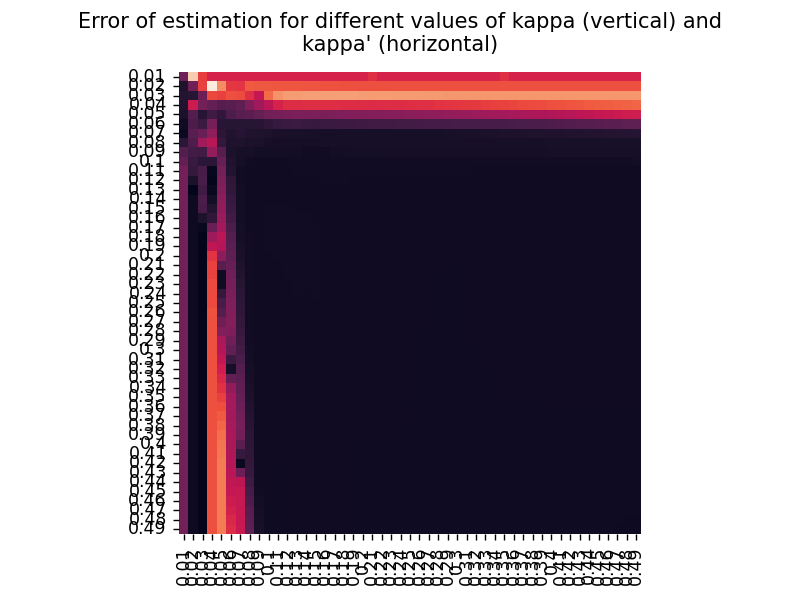

/tmp/ipykernel_29004/789895389.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [69]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

sns.heatmap(all_components_results_both.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax = fig.add_axes([.91, .3, .03, .4])
)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

<IPython.core.display.Javascript object>


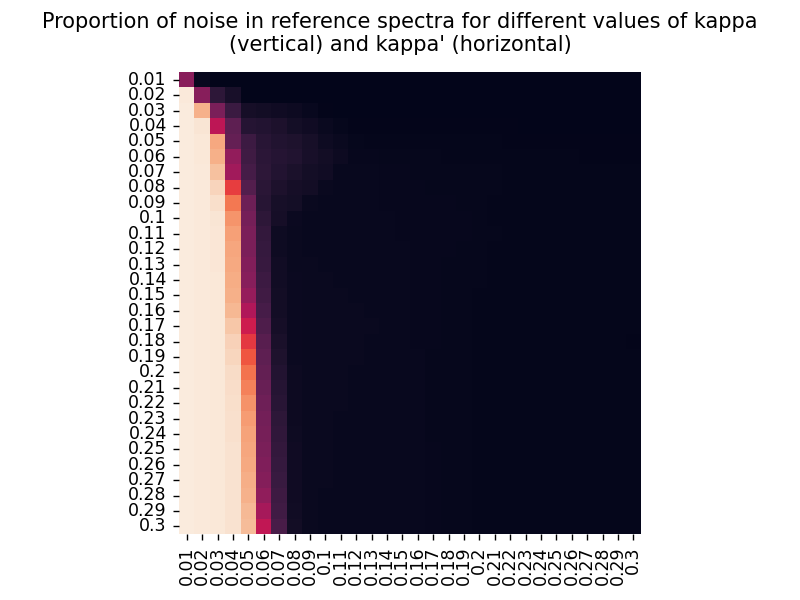

/tmp/ipykernel_29004/3035414201.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [82]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]][:30]

vmin = noise_in_theo_df.min().min()
vmax = noise_in_theo_df.max().max()

sns.heatmap(noise_in_theo_df.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax = fig.add_axes([.91, .3, .03, .4])
)

plt.suptitle('\n'.join(wrap("Proportion of noise in reference spectra for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [81]:
all_results_vis_molar_noise_prop = all_components_results_both.iloc[:30, :30] + noise_in_theo_df

<IPython.core.display.Javascript object>


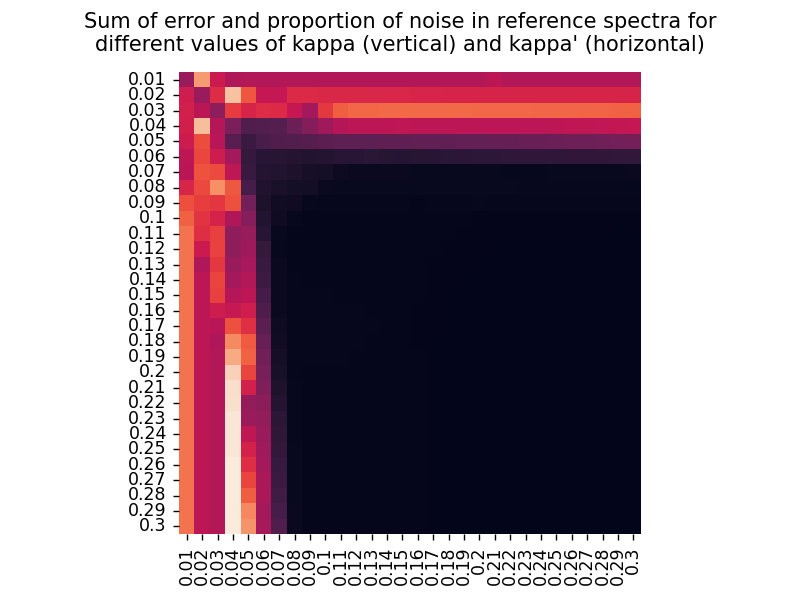

/tmp/ipykernel_29004/319897980.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [83]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]][:30]

vmin = all_results_vis_molar_noise_prop.min().min()
vmax = all_results_vis_molar_noise_prop.max().max()

sns.heatmap(all_results_vis_molar_noise_prop.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax = fig.add_axes([.91, .3, .03, .4])
)

plt.suptitle('\n'.join(wrap("Sum of error and proportion of noise in reference spectra for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [87]:
all_results_vis_molar_noise_prop.min().min()

0.08676750373760105

In [92]:
all_results_vis_molar_noise_prop[0.29000000000000004][0.20]

0.08676750373760105

### Estimation with best kappa

In [100]:
for i, sp in enumerate(spectra_and_mixture):
    try:
        np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
    except IndexError:
        np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')

In [93]:
estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=0.2, MTD_th=0.29, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 60.39it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(3.5000299999999998, 11.99995, 0), (3.5000299999999998, 11.99995, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(3.2100299999999997, 12.28995)]


Splitting the experimental spectrum into chunks: 139577it [00:00, 3413676.02it/s]


Ion currents in chunks: [0.9999999999999973]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Gurobi status= 2


Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.99s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9298597180920001
Noise proportion in experimental spectrum: 0.07014029297699982
Total explanation: 1.000000011069
Noise proportion in combination of theoretical spectra: 0.008558474193


In [55]:
estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=0.13, MTD_th=0.02, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 57.76it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(3.5000299999999998, 11.99995, 0), (3.5000299999999998, 11.99995, 1)]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 8019.70it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(3.37003, 12.129950000000001)]


Splitting the experimental spectrum into chunks: 139577it [00:00, 3455465.20it/s]


Ion currents in chunks: [0.9999999999999973]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 558307 rows, 139580 columns and 1349168 nonzeros
Model fingerprint: 0x6107178a
Coefficient statistics:
  Matrix range     [2e-12, 1e+00]
  Objective range  [2e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [2e-05, 1e-01]
Presolve removed 10422 rows and 0 columns (presolve time = 5s) ...
Presolve removed 25950 rows and 0 columns (presolve time = 10s) ...
Presolve removed 33336 rows and 0 columns (presolve time = 15s) ...
Presolve removed 38516 rows and 0 columns (presolve time = 20s) ...
Presolve removed 165574 rows and 0 columns
Presolve time: 95.82s
Presolved: 139580 rows, 558306 columns, 1349167 nonzeros

Concurrent LP opt

    3527 DPushes remaining with DInf 1.2593750e-04               382s
    3320 DPushes remaining with DInf 1.2593750e-04               399s
    3113 DPushes remaining with DInf 1.2593750e-04               416s
    2906 DPushes remaining with DInf 1.2593750e-04               433s
    2699 DPushes remaining with DInf 1.2593750e-04               451s
    2492 DPushes remaining with DInf 1.2593750e-04               468s
    2285 DPushes remaining with DInf 1.2593750e-04               486s
    2078 DPushes remaining with DInf 1.2593750e-04               503s
    1871 DPushes remaining with DInf 1.2593750e-04               521s
    1664 DPushes remaining with DInf 1.2593750e-04               538s
    1457 DPushes remaining with DInf 1.2593750e-04               556s
    1250 DPushes remaining with DInf 1.2593750e-04               573s
    1043 DPushes remaining with DInf 1.2593750e-04               590s
     836 DPushes remaining with DInf 1.2593750e-04               607s
     629 DPushes rem

Deconvolving chunks: 100%|███████████████████████| 1/1 [11:39<00:00, 699.53s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9998677946429999
Noise proportion in experimental spectrum: 0.00013220535900000007
Total explanation: 1.000000000002
Noise proportion in combination of theoretical spectra: 0.992582990536


In [94]:
estimation['proportion_of_noise_in_theoretical']

0.008558474192999977

In [95]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.43970247519399885, 0.49015724289799867]

In [96]:
1-sum(estimated_visible_proportions)

0.07014028190800248

In [97]:
real_visible_proportions

[0.468568053328833, 0.5314319466711671]

In [98]:
estimated_molar_proportions = [prop/prot for prop, prot in zip(estimated_visible_proportions, protons)]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.37423451120488055, 0.6257654887951195]

In [99]:
molar_proportions

[0.3702, 0.6298]

### Visualisation of our estimation

In [69]:
p = estimated_visible_proportions

In [70]:
p = np.array(p).reshape(len(p),1)

In [71]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [72]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [73]:
X = np.concatenate(components_ints, axis=1)

In [74]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


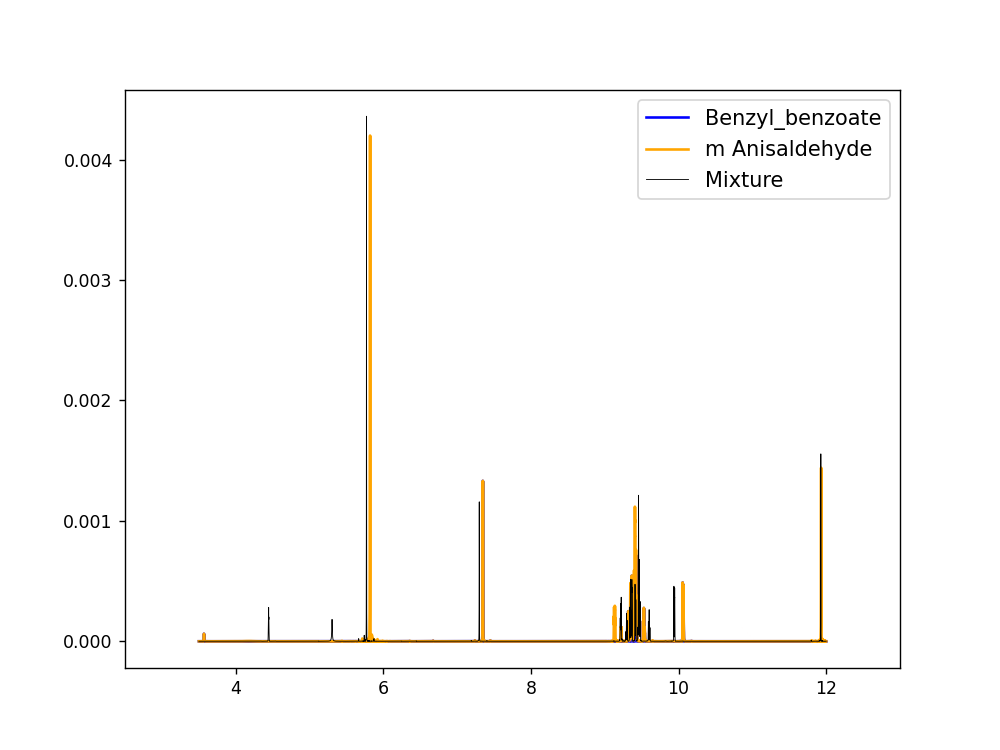

In [76]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
ax.set_xlim(2.5, 13)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})